# Practical Machine Learning for Physicists
## Week 6 Exercise 
## Deadline Monday 30th November at 12pm (Noon)

In this notebook you will be trying to predict a system using incomplete information. We will set up the equations of motions for a simple double pendulum (or should that be a double simple pendulum. Then we will see if a machine learning technique can predict the future position of the lower mass, using only the lower mass positions.

### Kinematics of the double pendulum
Let's specify our problem in terms of the following, with the origin at the pivot point of the top pendulum. This is just background for the machine learning tasks at the bottom of the notebook.

#### Positions
$$x_1 = L_1 \sin \theta_1$$
$$y_1 = -L_1 \cos \theta_1$$
$$x_2 = x_1 + L_2 \sin \theta_2$$
$$y_2 = y_1 - L_2 \cos \theta_2$$

#### Velocities
$$\dot{x}_1 = \dot{\theta_1} L_1 \cos \theta_1$$
$$\dot{y_1} =  \dot{\theta_1} L_1 \sin \theta_1$$
$$\dot{x_2} = \dot{x_1} + \dot{\theta_2} L_2 \cos \theta_2$$
$$\dot{y_2} = \dot{y_1} + \dot{\theta_2} L_2 \sin \theta_2$$


#### Accelerations

$$\ddot{x}_1 = -\dot{\theta_1}^2 L_1 \sin \theta_1 + \ddot{\theta_1} L_1 \cos \theta_1$$
$$\ddot{y_1} =  \dot{\theta_1}^2 L_1 \cos \theta_1 + \ddot{\theta_1} L_1 \sin \theta_1$$
$$\ddot{x_2} = \ddot{x_1} - \dot{\theta_2}^2 L_2 \sin \theta_2 + \ddot{\theta_2} L_2 \cos \theta_2$$
$$\ddot{y_2} = \ddot{y_1} + \dot{\theta_2}^2 L_2 \cos \theta_2 + \ddot{\theta_2} L_2 \sin \theta_2$$

#### Energies
Let $v_1^2 = \dot{x_1}^2 +\dot{y_1}^2$ and $v_2^2 = \dot{x_2}^2 +\dot{y_2}^2$ then the kinetic energies $T_1$ and $T_2$ are
$$ T_1 = \frac{1}{2}m_1 v_1^2 = \frac{1}{2}m_1 L_1^2 \dot{\theta_1}^2 $$
$$ T_2 = \frac{1}{2}m_2 v_2^2 = \frac{1}{2}m_2 \left( L_1^2 \dot{\theta_1}^2 + L_2^2 \dot{\theta_2}^2 + 2L_1 L_2 \cos(\theta_1-\theta_2) \dot{\theta_1} \dot{\theta_2} \right) $$

The potential enrgies are
$$V_1 = m_1 g y_1 = - m_1 g L_1 \cos \theta_1$$
$$V_2 = m_2 g y_2 = -m_2 g ( L_1 \cos \theta_1 + L_2 \cos \theta_2)$$

#### Langrangian
Now we form the Lagrangian $L=T-V=T_1+T_2 -V_1 -V_2$ and use the Euler-Lagrange equations:
$$\frac{\partial L}{\partial \theta_1} = \frac{d}{dt}\frac{\partial L}{\partial \dot{\theta_1}}$$
$$\frac{\partial L}{\partial \theta_2} = \frac{d}{dt}\frac{\partial L}{\partial \dot{\theta_2}}$$

Applying these gives
$$-(m_1+m_2) g L_1 \sin \theta_1 = (m_1+m_2) L_1^2 \ddot{\theta_1} + m_2 L_1 L_2 \sin(\theta_1-\theta_2) \dot{\theta_2}^2 +  m_2 L_1 L_2 \cos(\theta_1-\theta_2) \ddot{\theta_2} $$
and
$$ -m_2 g L_2 \sin \theta_2 = m_2 L_2 \ddot{\theta_2} + m_2 L_1 L_2 \cos(\theta_1-\theta_2) \ddot{\theta_1} + m_2 L_1 L_2 \sin(\theta_1-\theta_2) \dot{\theta_1}^2 $$ 


#### Equations of motions
$$ \omega_1 = \dot{\theta_1}$$  

$$ \omega_2 = \dot{\theta_2}$$ 
$$ \ddot\theta_1 = \frac{1}{L_1\xi}\left[L_1m_2\cos(\theta_1-\theta_2)\sin(\theta_1-\theta_2)\omega_1^2 + L_2m_2\sin(\theta_1-\theta_2)\omega_2^2 - m_2g\cos(\theta_1-\theta_2)\sin(\theta_2) + (m_1+m_2)g\sin(\theta_1) \right] $$
$$ \ddot\theta_2 = \frac{1}{L_2\xi}\left[L_2m_2\cos(\theta_1-\theta_2)\sin(\theta_1-\theta_2)\omega_2^2 + L_1(m_1+m_2)\sin(\theta_1-\theta_2)\omega_1^2+(m_1+m_2)g\sin(\theta_1)\cos(\theta_1-\theta_2) - (m_1+m_2)g\sin(\theta_2) \right] $$
where 
$$\xi \equiv \cos^2(\theta_1-\theta_2)m_2-m_1-m_2$$


In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.integrate import solve_ivp

import matplotlib.style #Some style nonsense
import matplotlib as mpl #Some more style nonsense

#Set default figure size
#mpl.rcParams['figure.figsize'] = [12.0, 8.0] #Inches... of course it is inches
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=200 # dots per inch



In [2]:
def rhs(t, z, L1, L2, m1, m2, g):
    """
    Returns the right-hand side of the ordinary differential equation describing the double pendulem
    """
    theta1, w1, theta2, w2 = z    #The four components
    cos12 = np.cos(theta1 - theta2)
    sin12 = np.sin(theta1 - theta2)
    sin1 = np.sin(theta1)
    sin2 = np.sin(theta2)
    xi = cos12**2*m2 - m1 - m2
    w1dot = ( L1*m2*cos12*sin12*w1**2 + L2*m2*sin12*w2**2
            - m2*g*cos12*sin2      + (m1 + m2)*g*sin1)/(L1*xi)
    w2dot = -( L2*m2*cos12*sin12*w2**2 + L1*(m1 + m2)*sin12*w1**2
            + (m1 + m2)*g*sin1*cos12  - (m1 + m2)*g*sin2 )/(L2*xi)
    return w1, w1dot, w2, w2dot   #Return the w's and the wdot's


def to_cartesian(theta1, w1, theta2, w2, L1, L2):
    """ Transforms theta and omega to cartesian coordinates
    and velocities x1, y1, x2, y2, vx1, vy1, vx2, vy2
    """
    x1 = L1 * np.sin(theta1)
    y1 = -L1 * np.cos(theta1)
    x2 = x1 + L2 * np.sin(theta2)
    y2 = y1 - L2 * np.cos(theta2)
    vx1 = L1*np.cos(theta1)*w1
    vy1 = L1*np.sin(theta1)*w1
    vx2 = vx1 + L2*np.cos(theta2)*w2
    vy2 = vy1 + L2*np.sin(theta2)*w2
    return x1, y1, x2, y2, vx1, vy1, vx2, vy2
    

In [3]:
# Set up the initial conditions. Here we have lengths and masses
L1, L2 = 1., 1.
m1, m2 = 3., 1.
g = 9.81     # [m/s^2]. Gravitational acceleration

#Starting angles
z0=[np.pi/4,0,np.pi/4,0]


#Time ranges
tmax, dt = 50, 0.1
t = np.arange(0, tmax+dt, dt)


In [4]:
# Solve initial value problem
ret = solve_ivp(rhs, (0,tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
z=ret.y
print(np.shape(z))

# Extract result
theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)

(4, 501)


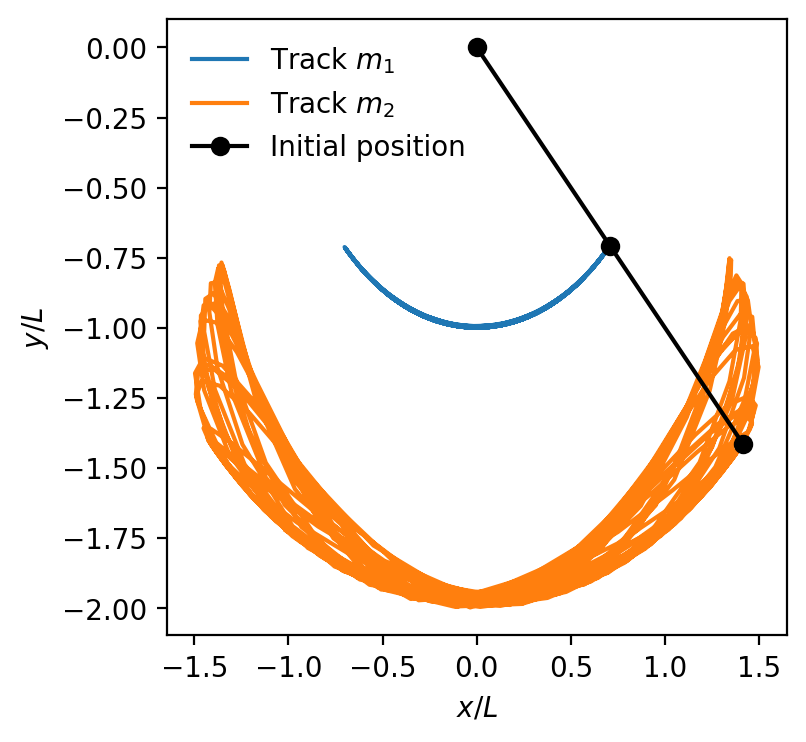

In [5]:
fig,ax=plt.subplots(figsize=(4,4))
ax.plot(x1, y1, label=r"Track $m_1$")
ax.plot(x2, y2, label=r"Track $m_2$")
ax.plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position", c='k')
plt.ylabel(r"$y/L$")
plt.xlabel(r"$x/L$")
ax.legend()

# Exercises: Predicting Chaos
1. Design and train a recurrent neural network (of your choice) to predict the future positions, where future is defined as $t=t_0 + 20 \delta t$, of the masses $m_1$ and $m_2$ using their cartesian coordinates and the initial conditions  $z_0=[\pi/4,0,\pi/4,0]$. 
2. How stable is your network to variations in initial conditions? Make a plot of $x$ and $y$ vs time to show the network prediction in comparison to the solution from solve_ivp
3. How far into the future can a network predict? Make a plot showing how the deviation between predicted position and actual position (from solve_ivp above) vary as a function of extrapolation time from $t=t_0 + 20 \delta t$ to $t=t_0 + 100 \delta t$  (e.g. for each extrapolation time, train a new version of the network and then plot the performance)
4. Repeat steps 1-3 for the initial conditions $z_0=[\pi/2,0,\pi/2,0]$ which give a much more complex path.
5. Repeat steps 1-4 but only train your neural network on the cartesian coordinates of the mass $m_2$ (i.e without showing your neural network the positions of the mass $m_1$)



## _WARNING!: FOR SOME FUNCTIONS IT WILL ASK WHETER U WANT TO VISUALIZE THE PLOT OR NOT_


1. Design and train a recurrent neural network (of your choice) to predict the future positions, where future is defined as 𝑡=𝑡0+20𝛿𝑡, of the masses 𝑚1 and 𝑚2 using their cartesian coordinates and the initial conditions 𝑧0=[𝜋/4,0,𝜋/4,0]. 

In [6]:
#imports
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
from scipy import linalg

#Useful for debugging problems
print(tf.__version__)

2023-03-05 01:12:19.733703: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.11.0


In [7]:
# RNN DESIGN

rnn=keras.models.Sequential([
    keras.layers.LSTM(50, input_shape=(None, 4)),
    keras.layers.Flatten(),
    keras.layers.Dense(192, activation='relu'),
    keras.layers.Dense(4, activation='linear'),])

#compile model
rnn.compile(loss='mean_squared_error', optimizer='adam')

rnn.summary()

2023-03-05 01:12:27.970340: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                11000     
                                                                 
 flatten (Flatten)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 192)               9792      
                                                                 
 dense_1 (Dense)             (None, 4)                 772       
                                                                 
Total params: 21,564
Trainable params: 21,564
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Now that we have the RNN lets split data into train/test
#train (60%)
y1_train=y1[0:int(0.6*len(y1))]
x1_train=x1[0:int(0.6*len(x1))]
y2_train=y2[0:int(0.6*len(y2))]
x2_train=x2[0:int(0.6*len(x2))]

#test (40%)
y1_test=y1[int(0.6*len(y1)):-1]
x1_test=x1[int(0.6*len(x1)):-1]
y2_test=y2[int(0.6*len(y2)):-1]
x2_test=x2[int(0.6*len(x2)):-1]

#make array for training and testing
data_test=np.column_stack((x1_test, y1_test, x2_test, y2_test)).T
data_train=np.column_stack((x1_train, y1_train, x2_train, y2_train)).T

#Create training/testing datasest to feed to the RNN
def dataset_gen(dataset,offset,windowsize):
    '''Generates input and output
    from the dataset given
    dataset -----> dataset being used
    offset  -----> how far into the future we can predict
    windowsize --> size of tensor that the network will use 
                    to predict the future positions
    '''
    #store input/output
    data,label=[],[]
    #loop over entire dataset
    for i in range(windowsize,len(dataset[0])-offset):
        #extract an item(input) of size (windowsize) of elements from i-windowsize to i
        item=dataset[:,(i-windowsize):i]
        
        #append item to corresponding lists
        data.append(item)
        label.append(dataset[:,i+offset])
    #turn lists into arrays
    data, label = np.array(data), np.array(label)
    return data, label

#Parameters
#steps
steps=1000
#windowsize could be regarded as batchsize which we will feed to the RNN
windowsize=30
#offset is how many steps do we wanna 'look' into the 'future' (predict)
offset=20

#Get data
train_inp, train_lbl = dataset_gen(data_train,offset,windowsize)
test_inp, test_lbl = dataset_gen(data_test,offset,windowsize)


#Let's have a look at how the data looks like:
print("The shape of the test data is",data_test.shape, "where the 4 rows are x1_test, y1_test, x2_test and y2_test")
print("The shape of the training data is",data_test.shape, "where the 4 rows are x1_train, y1_train, x2_train, y2_train")
print()
print("The shape of the training input data is",train_inp.shape)
print("The shape of the training label data is",train_lbl.shape)
print()
print("The shape of the test input data is",test_inp.shape)
print("The shape of the test label data is",test_lbl.shape)

The shape of the test data is (4, 200) where the 4 rows are x1_test, y1_test, x2_test and y2_test
The shape of the training data is (4, 200) where the 4 rows are x1_train, y1_train, x2_train, y2_train

The shape of the training input data is (250, 4, 30)
The shape of the training label data is (250, 4)

The shape of the test input data is (150, 4, 30)
The shape of the test label data is (150, 4)


In [9]:
def trainer_cost(model, train_inp, train_lbl, test_inp, test_lbl, steps):
    '''
    Trains the given RNN model on the train data (provided)
    and returns the training and test costs and also the predicted outputs
    
    Args:
    model ----> RNN model being trained on
    train_inp ----> Input data (training)
    train_lbl ----> Output data (training)
    test_inp  ----> Input data (test)
    test_lbl  ----> Output data (test)
    steps     ----> Number of training steps
    
    Returns:
    train_costs ---> Array of training costs at each step
    test_costs  ---> Array of test costs at each step
    pred        ---> Concatenated array of predicted outputs
    '''
        
    #Compile model to ensure that it is not trained
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    #Initialize arrays to store training and test costs
    train_costs=np.zeros(steps)
    test_costs=np.zeros(steps)

    #Loop through the steps and train model on batches of the training data
    for i in tqdm(range(steps)):
        #Reshape input and labels training data so that it fits and can be inputted into the rnn above:
        input_t= train_inp.reshape(train_inp.shape[0], windowsize, train_inp.shape[1])
        label_t= train_lbl.reshape(train_lbl.shape[0], train_inp.shape[1])
        train_costs[i]=model.train_on_batch(input_t, label_t)

        #Evaluate on test data
        input_test = test_inp.reshape(test_inp.shape[0], windowsize, test_inp.shape[1])
        label_test = test_lbl.reshape(test_lbl.shape[0], test_inp.shape[1])
        test_costs[i] = model.test_on_batch(input_test, label_test)

    #Predictions on train and test data
    input_train = train_inp.reshape(train_inp.shape[0], windowsize, train_inp.shape[1])
    input_test = test_inp.reshape(test_inp.shape[0], windowsize, test_inp.shape[1])
    pred_train = model.predict(input_train)
    pred_test = model.predict(input_test)

    #Concatenate train and test predictions
    pred = np.concatenate((pred_train, pred_test), axis=0)

    return train_costs, test_costs, pred


In [10]:
# Task 1 predictions and cost functions
train_costs_1, test_costs_1, pred_1 = trainer_cost(rnn, train_inp, train_lbl, test_inp, test_lbl, steps)

100%|███████████████████████████████████████| 1000/1000 [01:22<00:00, 12.11it/s]


5/5 [==============================] - 0s 8ms/step


Final loss of  0.00077578064519912


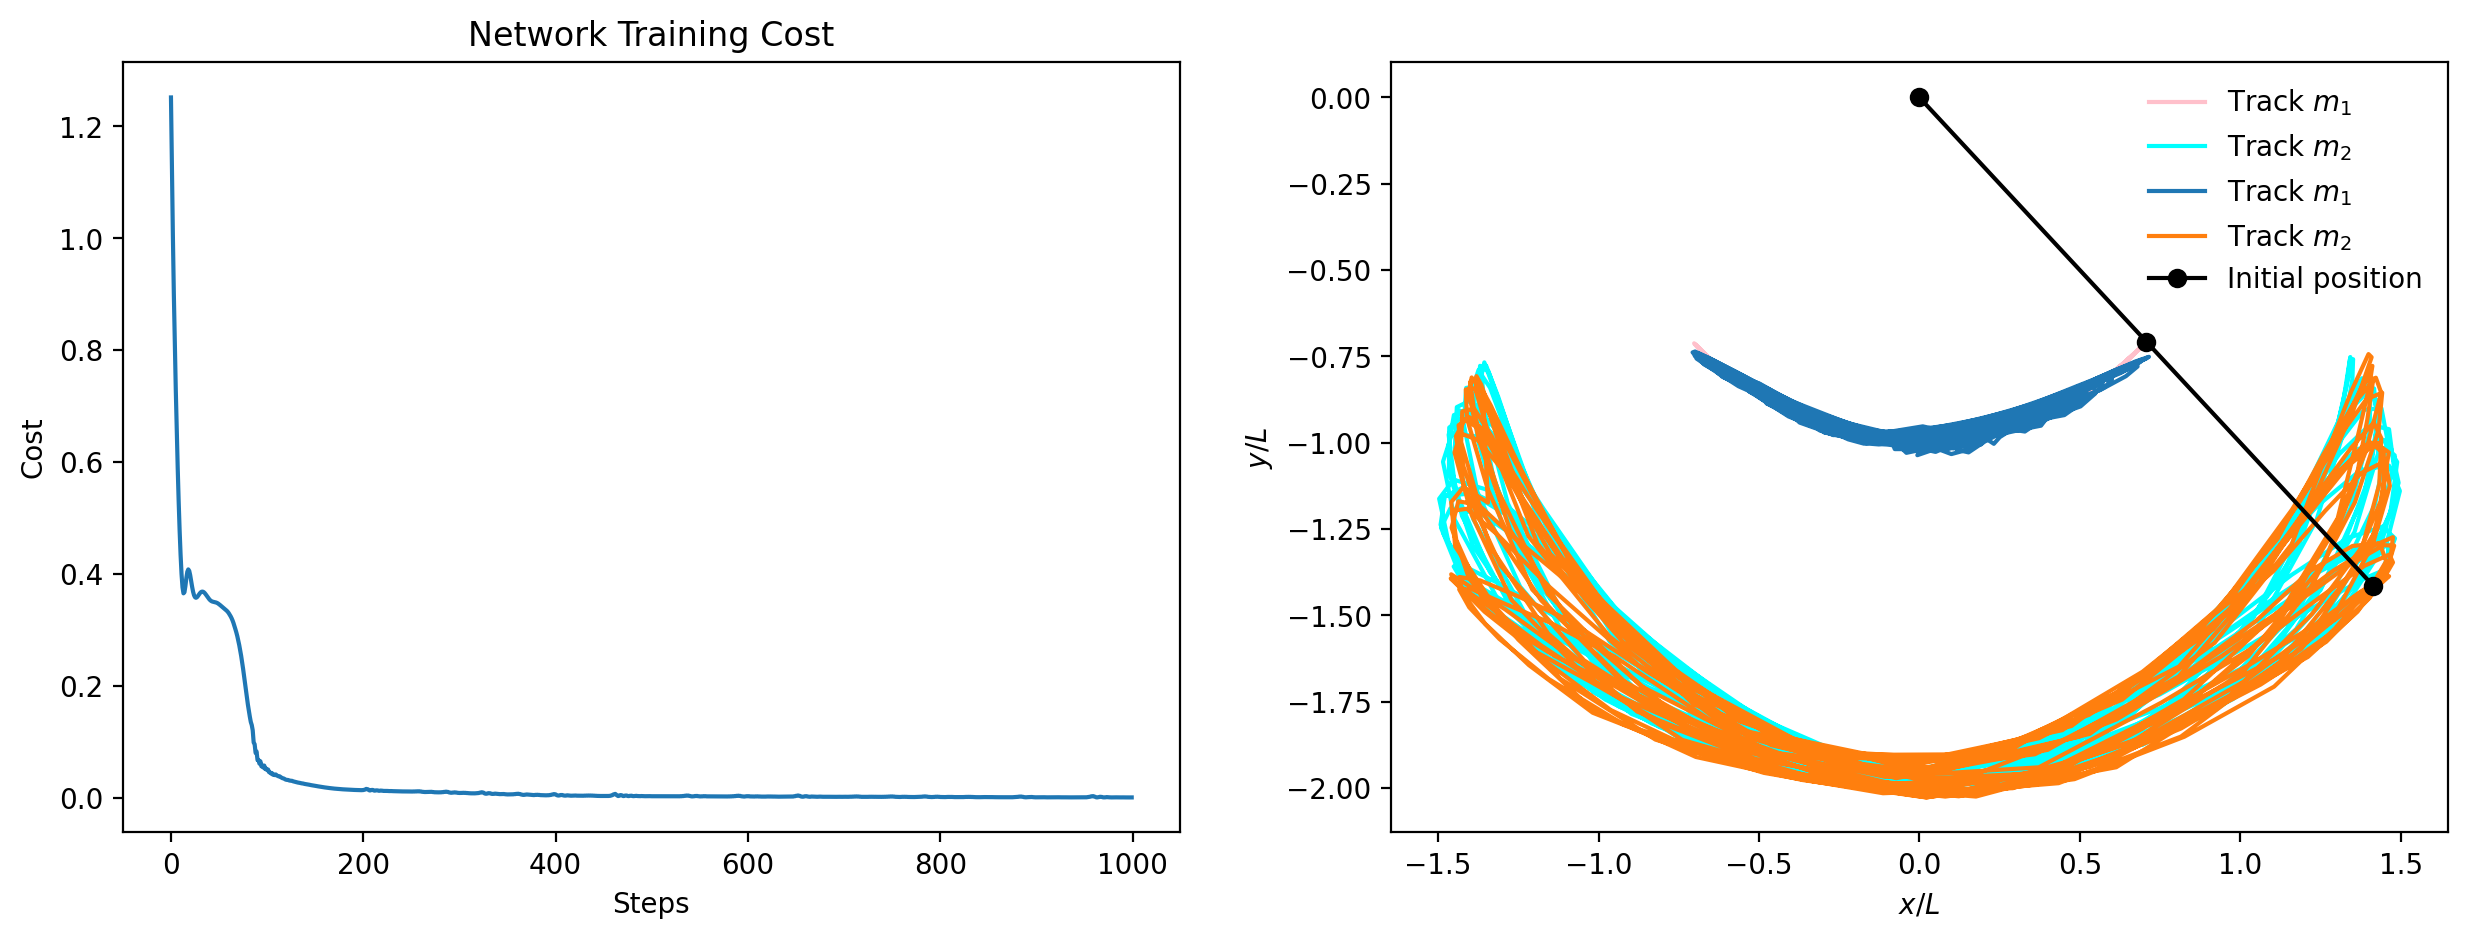

In [11]:
def costmodelplot(cost, steps,x1pred, y1pred, x2pred, y2pred,x1, x2, y1, y2):
    '''
    Plots the cost and model predictions of a given 
    training process for both masses
    
    Args:
    cost ----> 1D array containing the cost value of the training
    steps ---> Number of steps
    x1pred, y1pred, x2pred, y2pred ---> Arrays representing teh postitions of the two masses
    x1, x2, y1, y2  ----> Arrays of the positions of the two masses (Double-pendulum system)
    
    Returns:
                          PLOT
    '''
    #Set figure size
    fig,ax=plt.subplots(1,2, figsize=(15,5))
    #Plot of cost
    ax[0].plot(np.arange(steps),cost)
    
    #Plot labels and title
    ax[0].set_xlabel("Steps")
    ax[0].set_ylabel("Cost")
    ax[0].set_title("Network Training Cost")
    
    #Plot of original model
    ax[1].plot(x1, y1, label=r"Track $m_1$",c='pink')
    ax[1].plot(x2, y2, label=r"Track $m_2$",c='cyan')
    
    #Plot of model prediction
    ax[1].plot(x1pred, y1pred, label=r"Track $m_1$")
    ax[1].plot(x2pred, y2pred, label=r"Track $m_2$")
    ax[1].plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position", c='k')
    
    #Plot labels and title
    ax[1].set_ylabel(r"$y/L$")
    ax[1].set_xlabel(r"$x/L$")
    ax[1].legend()
    print('Final loss of ',cost[-1])#final cost

#Calling over all the steps pred[:,i] format
costmodelplot(test_costs_1, steps, pred_1[:,0],pred_1[:,1],pred_1[:,2],pred_1[:,3],x1,x2,y1,y2)



### Further visualisation

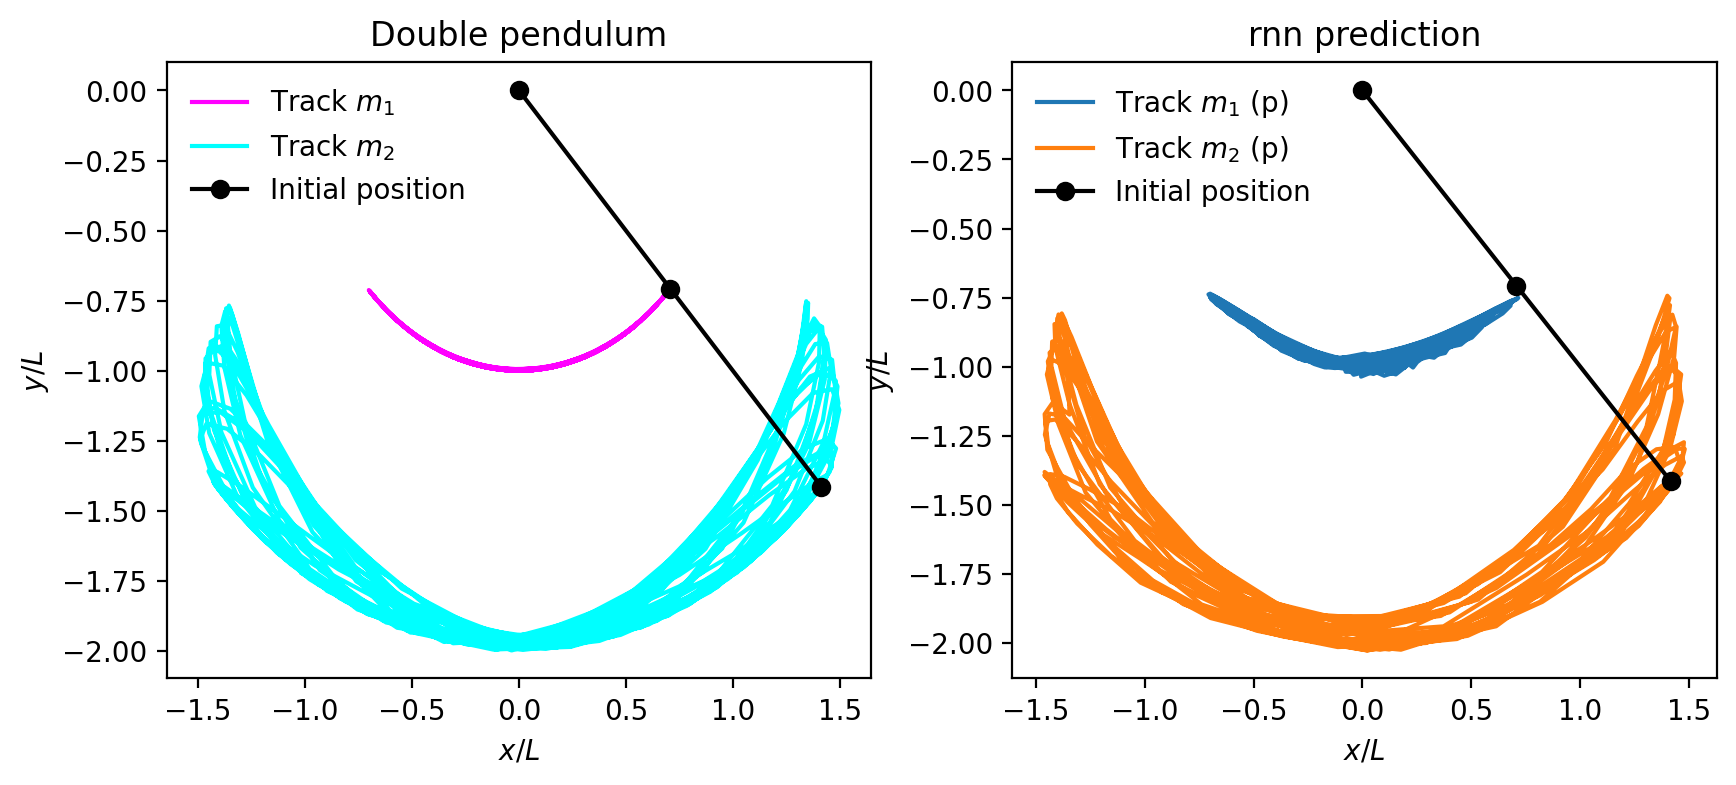

In [12]:
#COMPARATIVE PLOT
def comparative_plot(predictions, actual_val):
    
    '''
    Plot of the prediction vs original positions of the double pendulum
    Args:
    predictions ---> prediciton positions
    actual_val  ---> original double pendulum
    Returns:
                  PLOT
    '''
    #Set figure size
    fig,ax=plt.subplots(1,2, figsize=(10,4))
    
    #Original double pendulum positions
    ax[0].plot(actual_val[0], actual_val[2], label=r"Track $m_1$",c='magenta')
    ax[0].plot(actual_val[1], actual_val[3], label=r"Track $m_2$",c='cyan')
    #Origin positions
    ax[0].plot([0, actual_val[0][0], actual_val[1][0]], [0, actual_val[2][0], actual_val[3][0]], "-o", label="Initial position", c='k')
    #Plot labels and title
    ax[0].set_ylabel(r"$y/L$")
    ax[0].set_xlabel(r"$x/L$")
    ax[0].set_title('Double pendulum')
    ax[0].legend()
    
    #Predicted double pendulum postions
    ax[1].plot(predictions[:,0], predictions[:,1], label=r"Track $m_1$ (p)")
    ax[1].plot(predictions[:,2], predictions[:,3], label=r"Track $m_2$ (p)")
    #Origin positions
    ax[1].plot([0, actual_val[0][0], actual_val[1][0]], [0, actual_val[2][0], actual_val[3][0]], "-o", label="Initial position", c='k')
    #Plot labels and title
    ax[1].set_ylabel(r"$y/L$")
    ax[1].set_xlabel(r"$x/L$")
    ax[1].set_title('rnn prediction')
    ax[1].legend()

pend_sol=(x1,x2,y1,y2)#store pendulum solutions from solve_ivp
comparative_plot(pred_1, pend_sol)


Let's create the data that we will use to feed the RNN to predict the next steps of the double pendulum.

## Task 2
- How stable is your network to variations in initial conditions? Make a plot of 𝑥 and 𝑦 vs time to show the network prediction in comparison to the solution from solve_ivp

In [13]:
def account_variations(zi,tmax,dt,model=rnn,steps=steps,windowsize=windowsize,offset=offset):
    '''Function that checks for variations'''
    
    #####################################################################################
    # First lets get new results of x1,x2,y1,y2 for the variation on initial conditions #
    #####################################################################################
    
    #Initial conditions
    z0=zi
    #New time to avoid problems
    t = np.arange(0, tmax+dt, dt)
    #Solve the system (with same masses and lengths as before) COULD IMPLEMENT A CHANGE IN THIS!
    ret = solve_ivp(rhs, (0,tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
    z=ret.y
    #Extract result
    theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
    x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)
    solution=(x1, x2, y1, y2)
    #train (60%)
    y1_train=y1[0:int(0.6*len(y1))]
    x1_train=x1[0:int(0.6*len(x1))]
    y2_train=y2[0:int(0.6*len(y2))]
    x2_train=x2[0:int(0.6*len(x2))]

    #test (40%)
    y1_test=y1[int(0.6*len(y1)):-1]
    x1_test=x1[int(0.6*len(x1)):-1]
    y2_test=y2[int(0.6*len(y2)):-1]
    x2_test=x2[int(0.6*len(x2)):-1]

    #make array for training and testing

    data_test=np.column_stack((x1_test, y1_test, x2_test, y2_test)).T
    data_train=np.column_stack((x1_train, y1_train, x2_train, y2_train)).T


    train_inp, train_lbl = dataset_gen(data_train,offset,windowsize)
    test_inp, test_lbl = dataset_gen(data_test,offset,windowsize)


    
    
        ###############################################################################
        #  Now let's repeat part 1 create data to predict the double pendulum system  #
        ###############################################################################


    train_costs, test_costs, pred = trainer_cost(model, train_inp, train_lbl, test_inp, test_lbl, steps)

                                                

                ###############################################################
                #  Now let's plot our results for the double pendulum system  #
                ###############################################################
    answer=input("Do you want to plot the cost functions of test and train (yes/no) ")
    if answer.lower() == 'yes':

        fig,ax=plt.subplots(1,2, figsize=(15,5))
        #plot of cost
        ax[0].plot(np.arange(steps),train_costs)
        ax[1].plot(np.arange(steps),test_costs)

        # Plot labels and title
        ax[0].set_xlabel("Steps")
        ax[0].set_ylabel("Cost")
        ax[0].set_title("Network Training Cost")
        ax[1].set_xlabel("Steps")
        ax[1].set_ylabel("Cost")
        ax[1].set_title("Network Testing Cost")

        
        return pred,solution,train_costs, t


    elif answer.lower()=='no':

        return pred,solution,train_costs, t
    
    

In [14]:
#Now let's plot x and y over time for different initial conditions
def plot_motion_overtime(pred,val,t,tlimit):
    '''
    Plot the motion of the double pendulum (original vs predicted by RNN)
    over time
    Args:
    pred ----> Predicted positions of the double pendulum
    val  ----> Orignal (solve_ivp) positions of the double pendulum
    t    ----> Time
    tlimit --> Limit in time
    Returns:
                 4 PLOTS (one for each component)
    '''
    #Set figsize
    fig,ax=plt.subplots(4,1,figsize=(14,10))
    #add space in between the different plots
    plt.subplots_adjust(hspace=0.8)
    
    #Plot x1 over time
    ax[0].plot(t, val[0],label=r"$x1_{True}$")
    #Plot x1(prediction) over time
    ax[0].plot(t[(len(t)-len(pred[:,0])):],pred[:,0],label=r"$x1_{Prediction}$")
    ax[0].set_xlim(tlimit[0],tlimit[1])#limit
    ax[0].set_xlabel('time')
    ax[0].set_ylabel('x1')
    ax[0].legend()
    ax[0].set_title('rnn prediction of initial conditions')
    
    #Plot y1 over time
    ax[1].plot(t, val[1],label=r"$x2_{True}$")
    #Plot y1(prediction) over time
    ax[1].plot(t[(len(t)-len(pred[:,2])):],pred[:,2],label=r"$x2_{Prediction}$")
    ax[1].set_xlim(tlimit[0],tlimit[1])#limit
    ax[1].set_xlabel('time')
    ax[1].set_ylabel('x2')
    ax[1].legend()
    ax[1].set_title('rnn prediction of initial conditions')
    
    #Plot x2 over time
    ax[2].plot(t, val[2],label=r"$y1_{True}$")
    #Plot x2(prediction) over time
    ax[2].plot(t[(len(t)-len(pred[:,1])):],pred[:,1],label=r"$y1_{Prediction}$")
    ax[2].set_xlim(tlimit[0],tlimit[1])#limit
    ax[2].set_xlabel('time')
    ax[2].set_ylabel('y1')
    ax[2].legend()
    ax[2].set_title('rnn prediction of initial conditions')
    
    #Plot y2 over time
    ax[3].plot(t, val[3],label=r"$y2_{True}$")
    #Plot y2(prediction) over time
    ax[3].plot(t[(len(t)-len(pred[:,0])):],pred[:,3],label=r"$y2_{Prediction}$")
    ax[3].set_xlim(tlimit[0],tlimit[1])#limit
    ax[3].set_xlabel('time')
    ax[3].set_ylabel('y2')
    ax[3].legend()
    ax[3].set_title('rnn prediction of initial conditions')
#set limit from 0 to 50    
tlim=(0,50)


### Visualisation
- After finishing all the needed functions for task 2 let's compare our model(rnn) with different initial conditions.

RNN WITH INITIAL CONDITIONS ($\pi/4$, 0,$\pi/4$, 0)


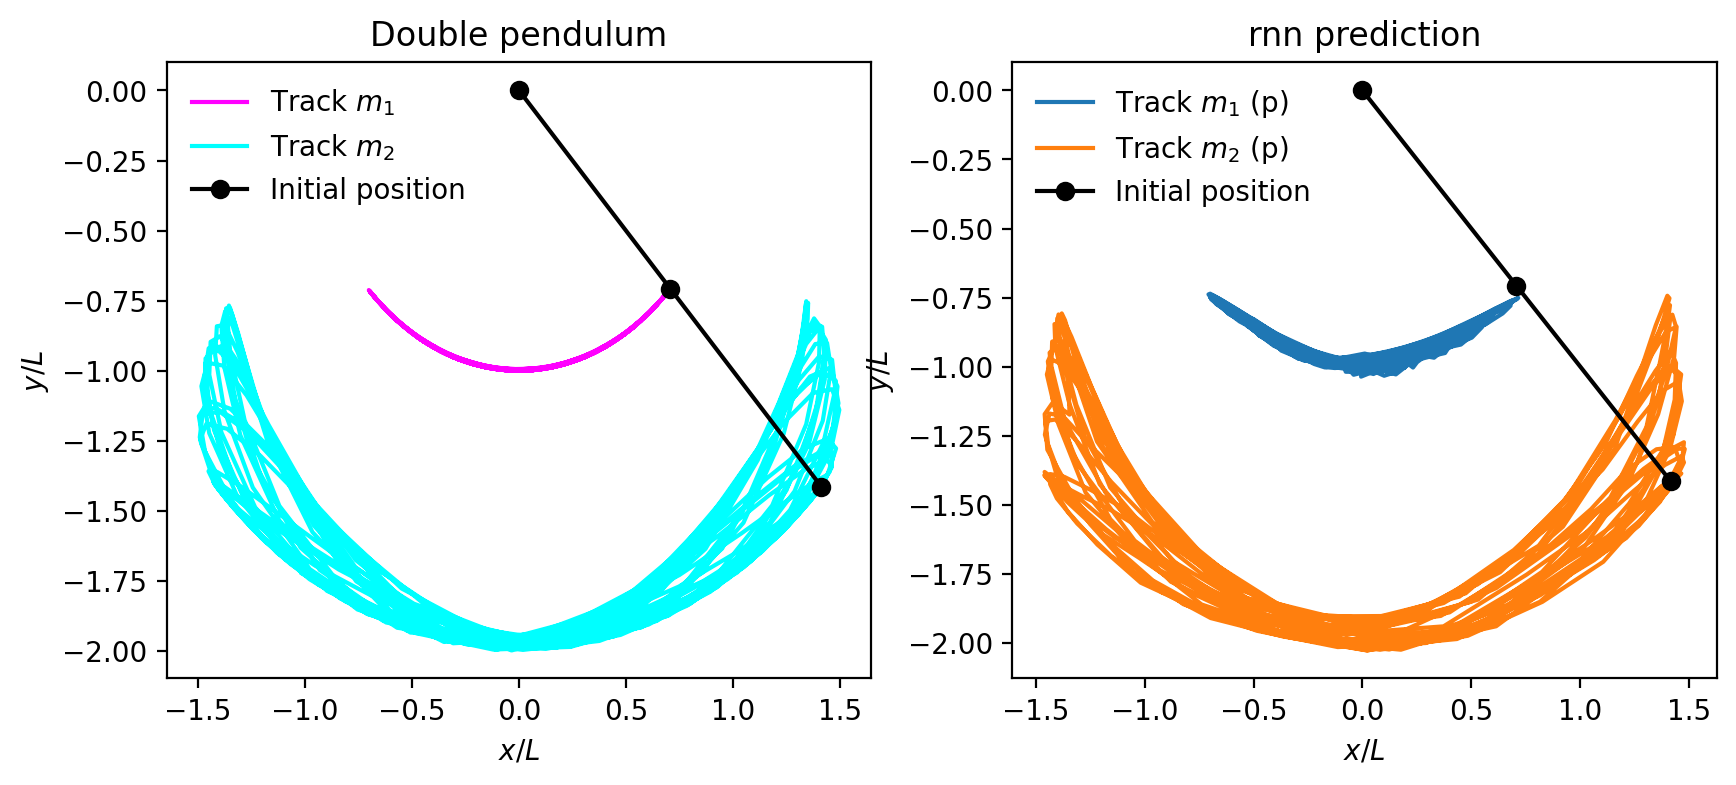

In [15]:
#First plot how the model performs compare to the actual double pendulum (as before)
comparative_plot(pred_1, pend_sol)


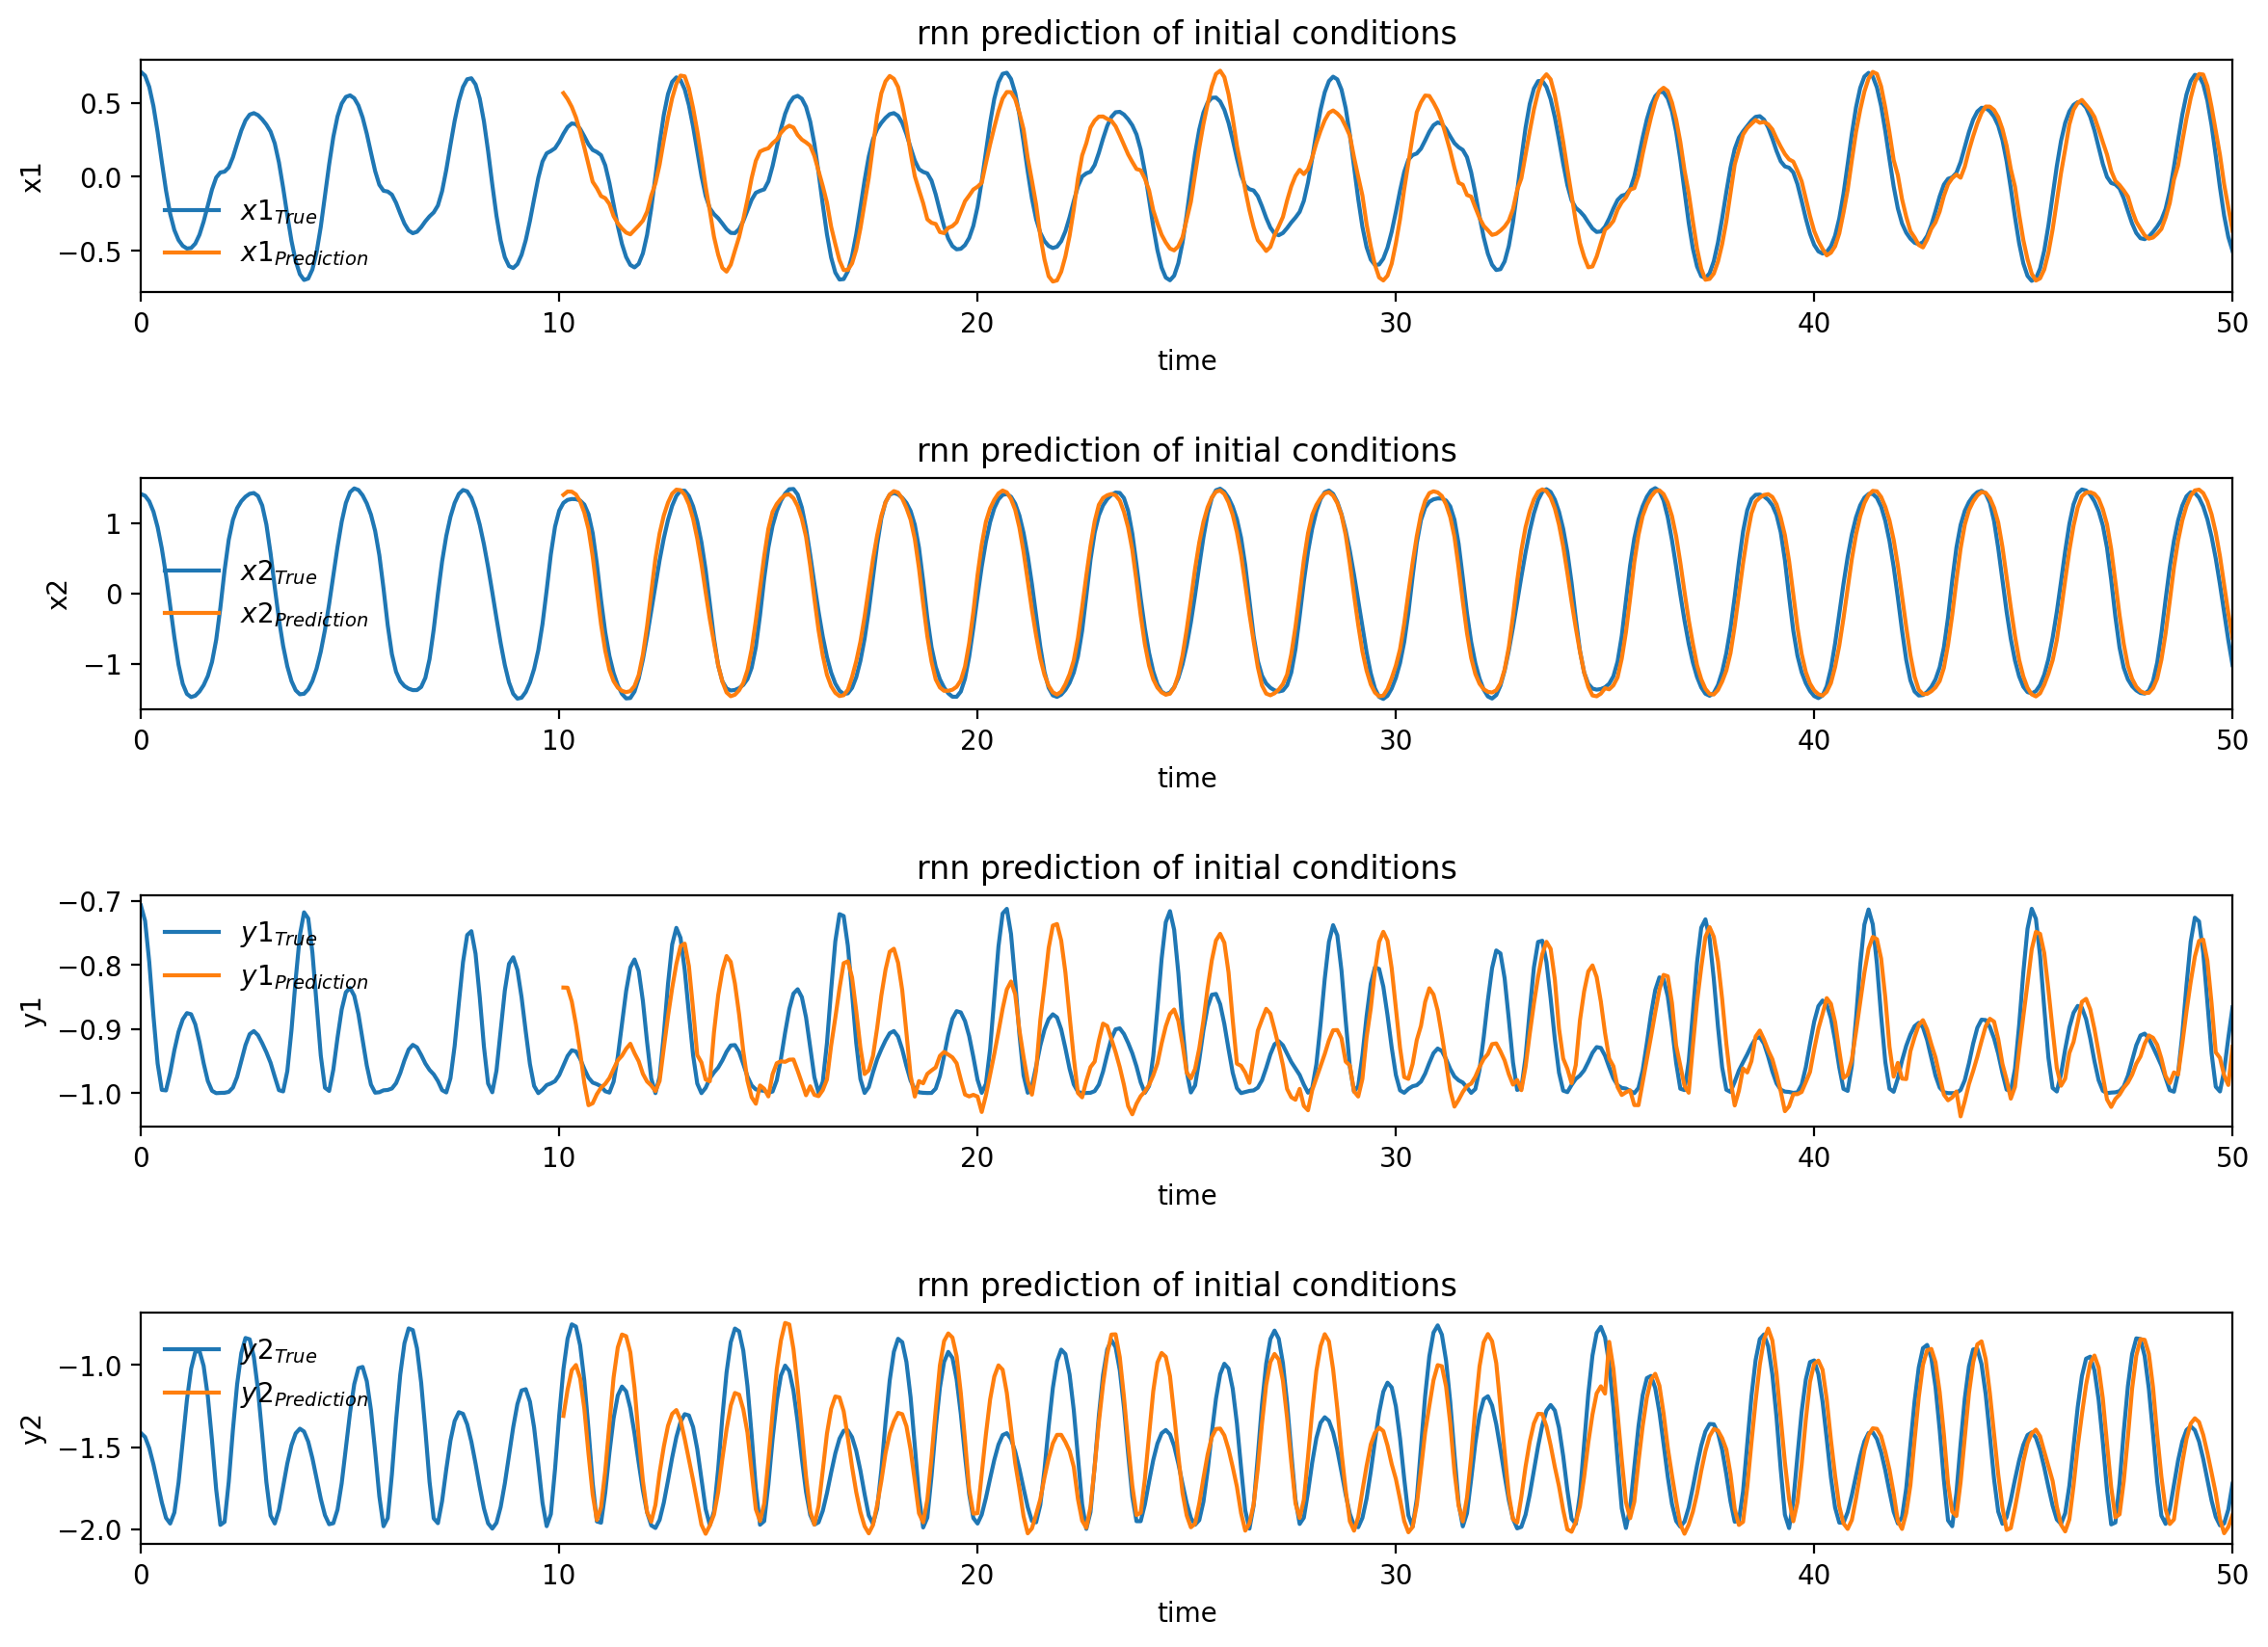

In [16]:
#Plot x and y over time Original vs Predicted
plot_motion_overtime(pred_1, pend_sol,t,tlim)


### Comments:
  - It can be stated from the plots that the rnn model performs well predicitng the positions of the two masses on the double pendulum.
Specially for more periodic motions (x2), as the predictions smoothly follows the positon of the mass 2 on x.
The rnn learns from the timesteps before $t_o$.

- A conclusion from these results is that the rnn model performs better on periodic systems and could potentially perform worst on more chaotic systems.

RNN WITH INITIAL CONDITIONS ($\pi/3$, 0,$\pi/3$, 2)


100%|███████████████████████████████████████| 1000/1000 [01:17<00:00, 12.95it/s]


5/5 [==============================] - 0s 8ms/step
Do you want to plot the cost functions of test and train (yes/no) yes


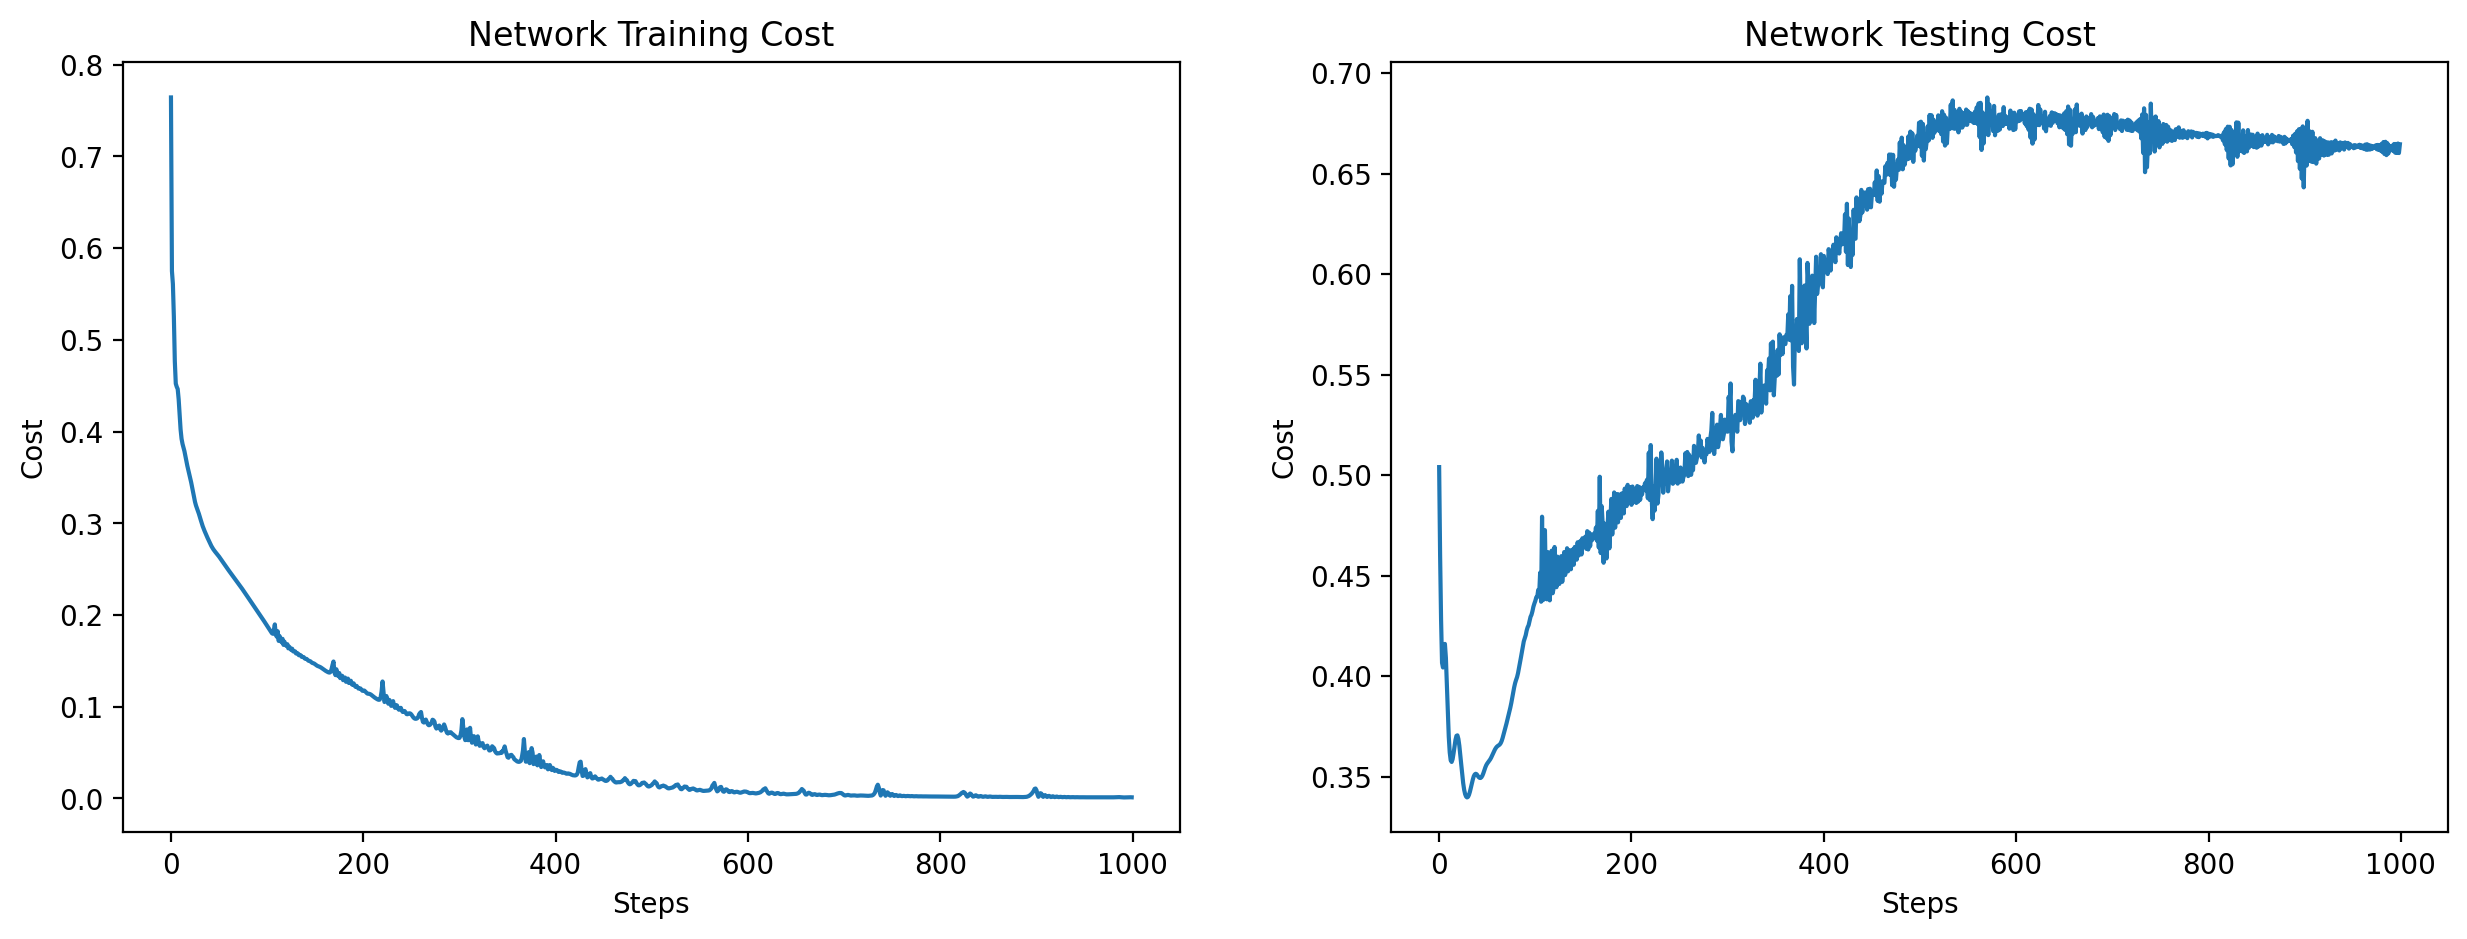

In [17]:
#Different initial conditions let's train the RNN on the 
# new initial conditions for (π/3, 0,π/3, 2) and get new data
z_var=[np.pi/3,0,np.pi/3,2]
pred_v1,pend_sol_v1,cost_v1, t_v1=account_variations(z_var,tmax,dt,rnn,steps,windowsize,offset)



0.6823591114814911


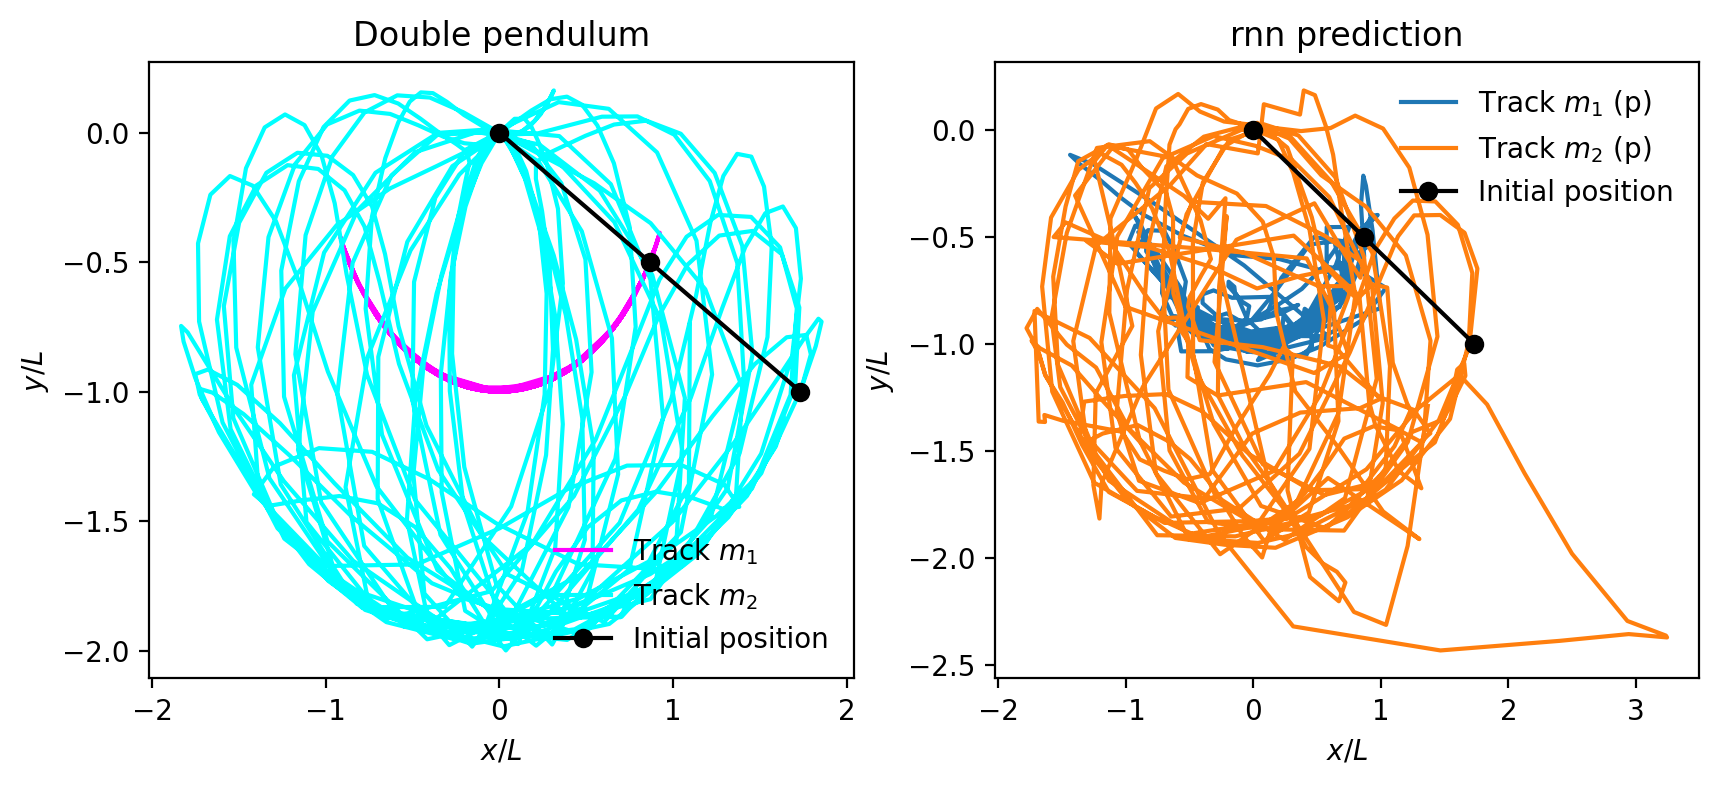

In [18]:
#First plot how the model performs 
# compare to the actual double pendulum for (π/3, 0,π/3, 2)
comparative_plot(pred_v1,pend_sol_v1)
print(x1[1])

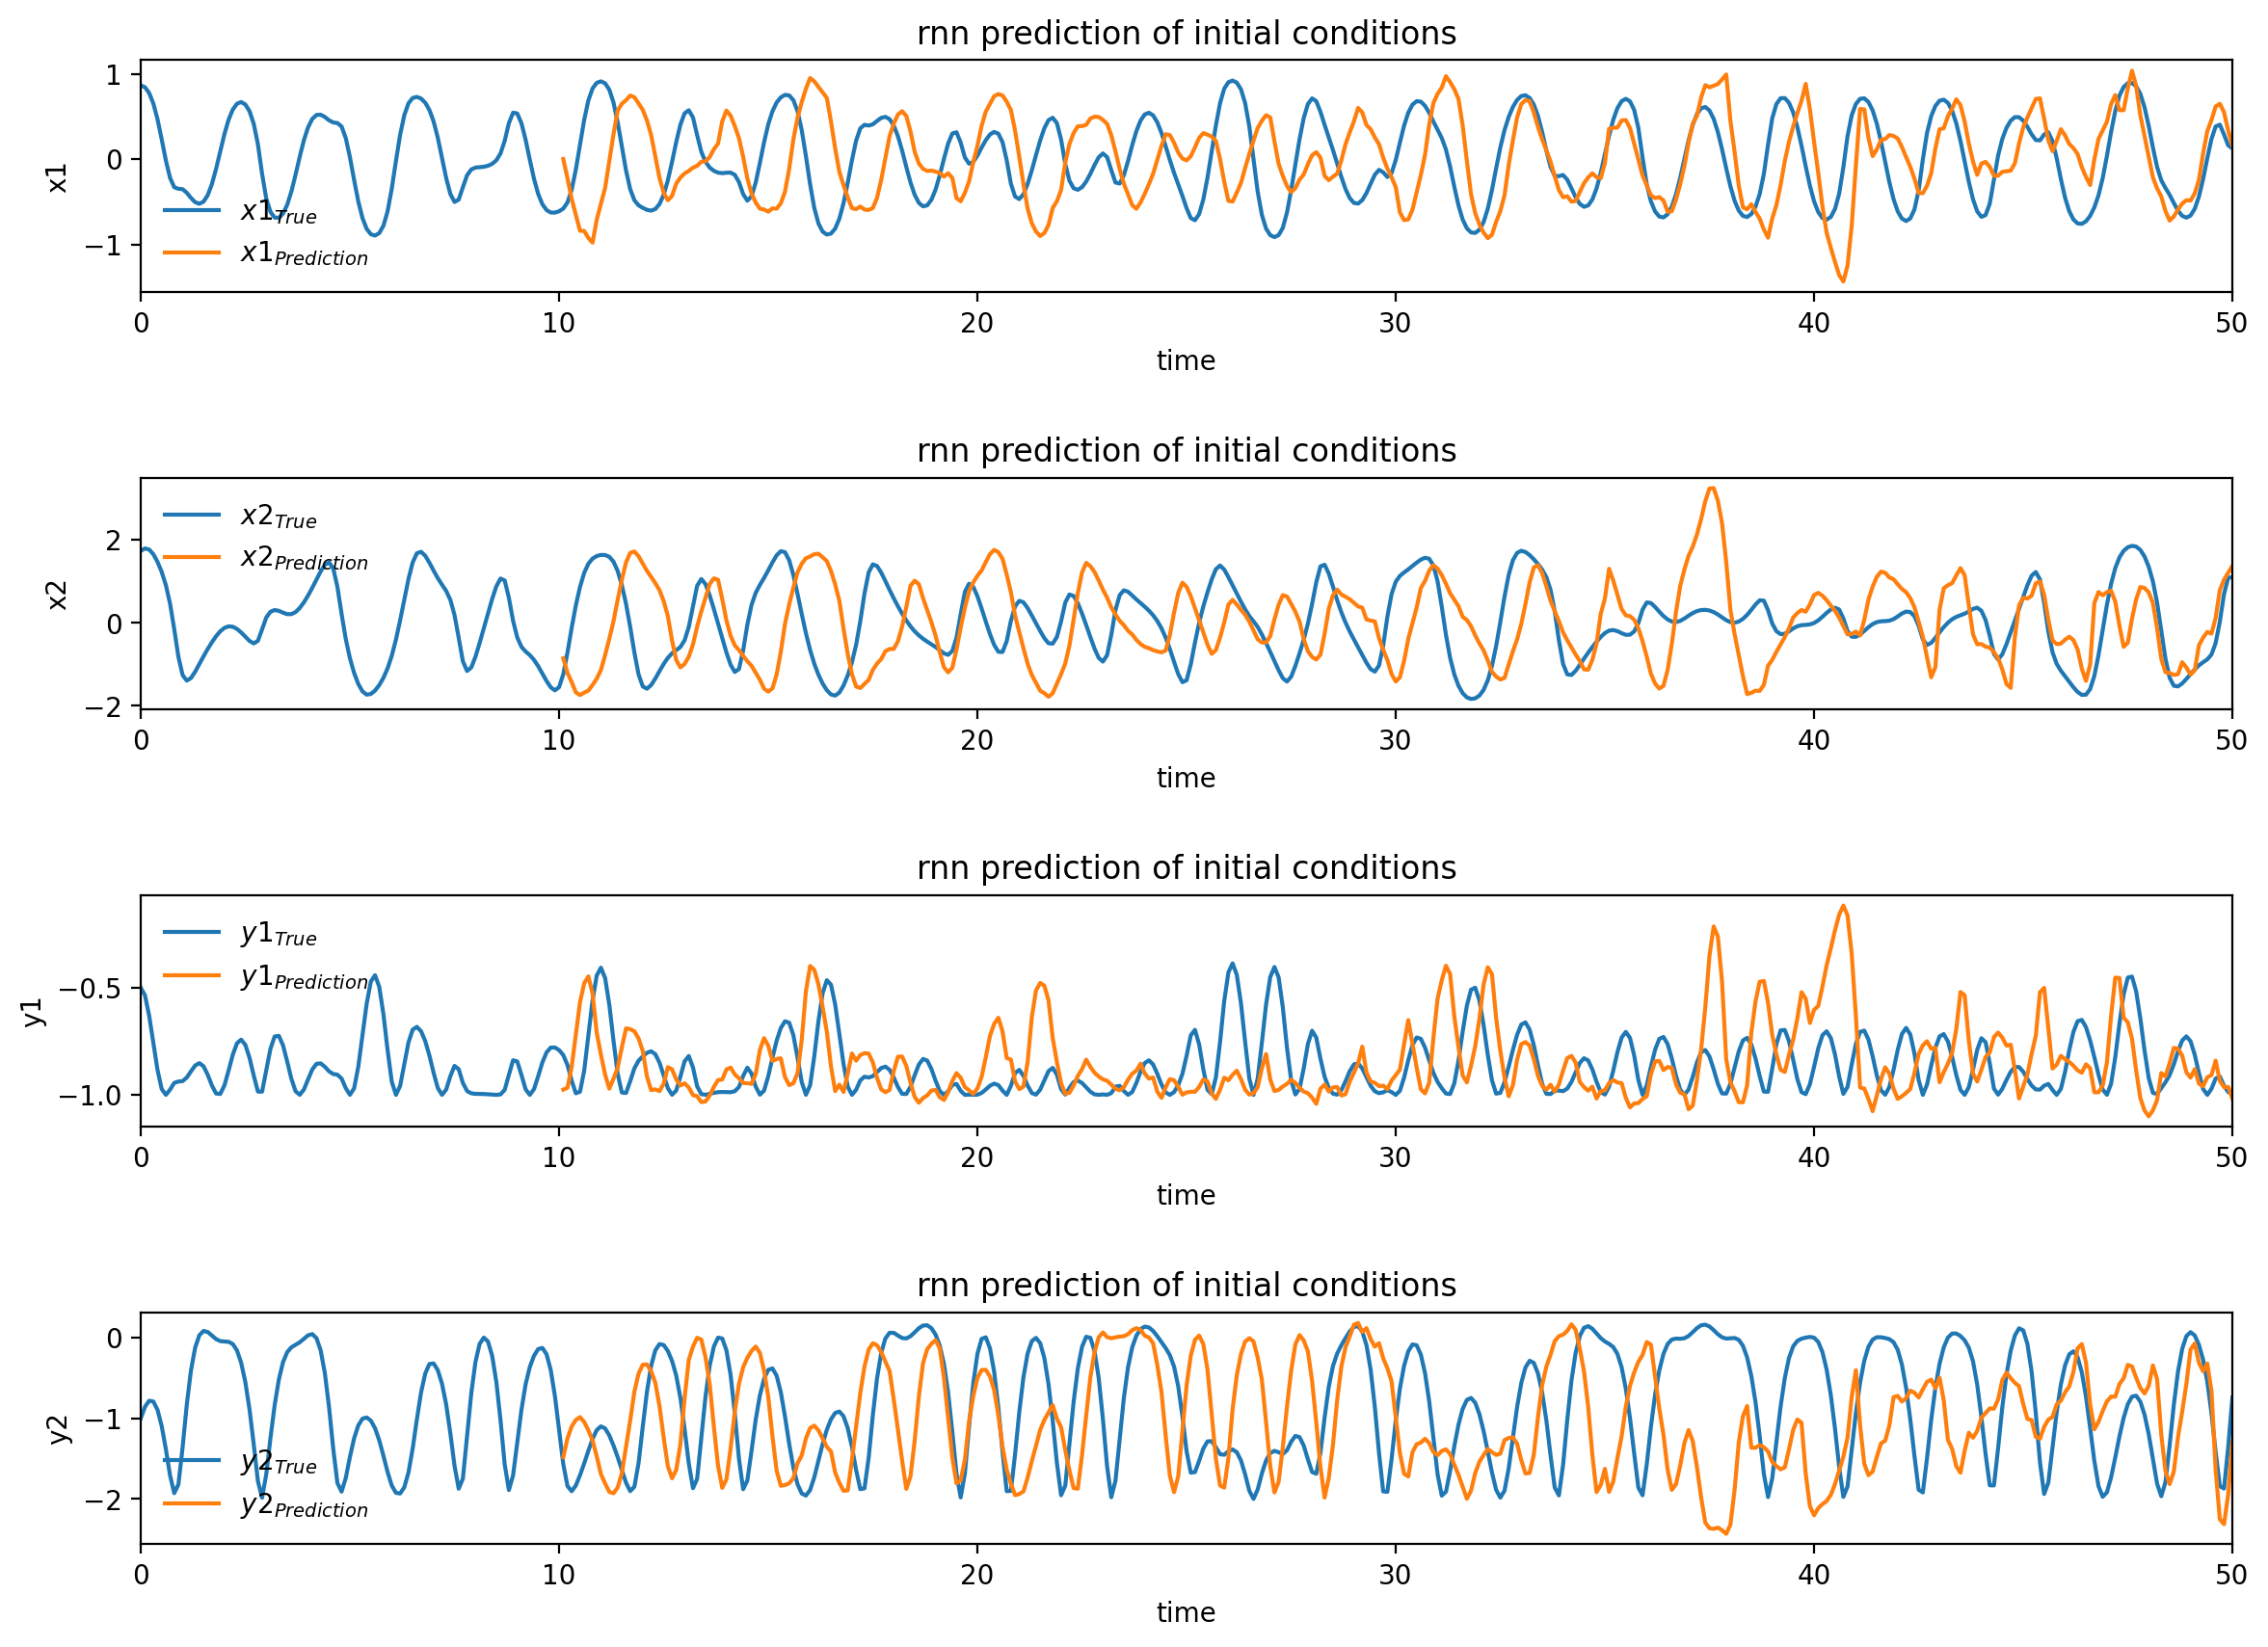

In [19]:
#Plot x and y over time for (π/3, 0,π/3, 2)
plot_motion_overtime(pred_v1,pend_sol_v1,t_v1,tlim)


### Comments
- As we deviate a bit from the inital angles from before in this case: (π/3, 0,π/3, 2) we get a totally different result and a much worst prediction.

## Task 3
- How far into the future can a network predict? Make a plot showing how the deviation between predicted position and actual position (from solve_ivp above) vary as a function of extrapolation time from 𝑡=𝑡0+20𝛿𝑡 to 𝑡=𝑡0+100𝛿𝑡 (e.g. for each extrapolation time, train a new version of the network and then plot the performance)

In [20]:
#Let's find this deviation as a function of extrapolation time from 𝑡=𝑡0+20𝛿𝑡 to 𝑡=𝑡0+100𝛿𝑡
#define model generator to create x models to train over teh different offsets
def modelgenerator():
    genmodel=keras.models.Sequential()
    #LSTM layer with 50 neurons.
    genmodel.add(keras.layers.LSTM(50,input_shape=(None, 4)))#Input shape is 4 for each x1,x2,y1 and y2
    genmodel.add(keras.layers.Flatten())#Flatten                           #from sequential to flat NN:
    genmodel.add(keras.layers.Dense(192, activation='relu'))
    genmodel.add(keras.layers.Dense(4, activation='linear'))#output layer with 4 nueron for each x1, x2, y1 or y2
    #Compile the model with 'adam' optimizer being used.
    genmodel.compile(loss='mean_squared_error',optimizer='adam')
    
    return genmodel

#Define the offset for task 3
offset_3=(20,101,5)

#store all the 17 models (17 cause its the number of offsets defined on offset_3)
model_array = []

for i in range(17):
    modelgen = modelgenerator()
    model_array.append(modelgen)
    
    

In [21]:


def train_offsets(z0,offsets,windowsize,models_array):

    # Set up the initial conditions. Here we have lengths and masses

    #Time ranges
    t3 = np.arange(0, tmax+dt, dt)
    #Solve initial value problem
    ret3 = solve_ivp(rhs, (0,tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
    z3=ret3.y

    #Extract result
    theta1_3, w1_3, theta2_3, w2_3 = z3[0], z3[1], z3[2], z3[3]
    x1_3, y1_3, x2_3, y2_3, vx1_3, vy1_3, vx2_3, vy2_3 = to_cartesian(theta1_3, w1_3, theta2_3, w2_3, L1, L2)

    #train (60%)
    y1_train_3=y1_3[0:int(0.6*len(y1_3))]
    x1_train_3=x1_3[0:int(0.6*len(x1_3))]
    y2_train_3=y2_3[0:int(0.6*len(y2_3))]
    x2_train_3=x2_3[0:int(0.6*len(x2_3))]

    #test (40%)
    y1_test_3=y1_3[int(0.6*len(y1_3)):-1]
    x1_test_3=x1_3[int(0.6*len(x1_3)):-1]
    y2_test_3=y2_3[int(0.6*len(y2_3)):-1]
    x2_test_3=x2_3[int(0.6*len(x2_3)):-1]


    #make array for training and testing
    data_test_3=np.column_stack((x1_test_3, y1_test_3, x2_test_3, y2_test_3)).T
    data_train_3=np.column_stack((x1_train_3, y1_train_3, x2_train_3, y2_train_3)).T
    #store solve_ivp solution
    solution_3=(x1_3, x2_3, y1_3, y2_3)
    #offsets
    offset_3=range(*offsets)

    #storages for train and test
    inp_train_3=[]
    lbl_train_3=[]
    inp_test_3=[]
    lbl_test_3=[]
    
    #Loop over all offsets
    for offset in offset_3:
        #training and testing datasets for RNN
        train_inp_3, train_lbl_3 = dataset_gen(data_train_3,offset,windowsize)
        test_inp_3, test_lbl_3 = dataset_gen(data_test_3,offset,windowsize)
    

        #reshape
        input_train=train_inp_3.reshape(train_inp_3.shape[0],windowsize, train_inp_3.shape[1])
        label_train=train_lbl_3.reshape(train_lbl_3.shape[0], train_inp_3.shape[1])
        input_test=test_inp_3.reshape(test_inp_3.shape[0],windowsize, test_inp_3.shape[1])
        label_test=test_lbl_3.reshape(test_lbl_3.shape[0], test_inp_3.shape[1])
        
        #store values
        inp_train_3.append(input_train)
        lbl_train_3.append(label_train)
        inp_test_3.append(input_test)
        lbl_test_3.append(label_test)
        
    #TRAINING
    #store loss
    loss=[]
    for i in range(len(offset_3)):
        model=models_array[i]
        history=model.fit(inp_train_3[i], lbl_train_3[i], epochs=33,
                          validation_data= (inp_test_3[i],lbl_test_3[i] ), verbose=0)
        test_loss = model.evaluate(inp_test_3[i], lbl_test_3[i] , verbose=1)
        loss.append(test_loss)
        
    return loss
        

In [22]:
#Get loss of training over the different offsets
loss_3=train_offsets(z0,offset_3,windowsize,model_array)


3/3 [==============================] - 0s 8ms/step - loss: 0.0198


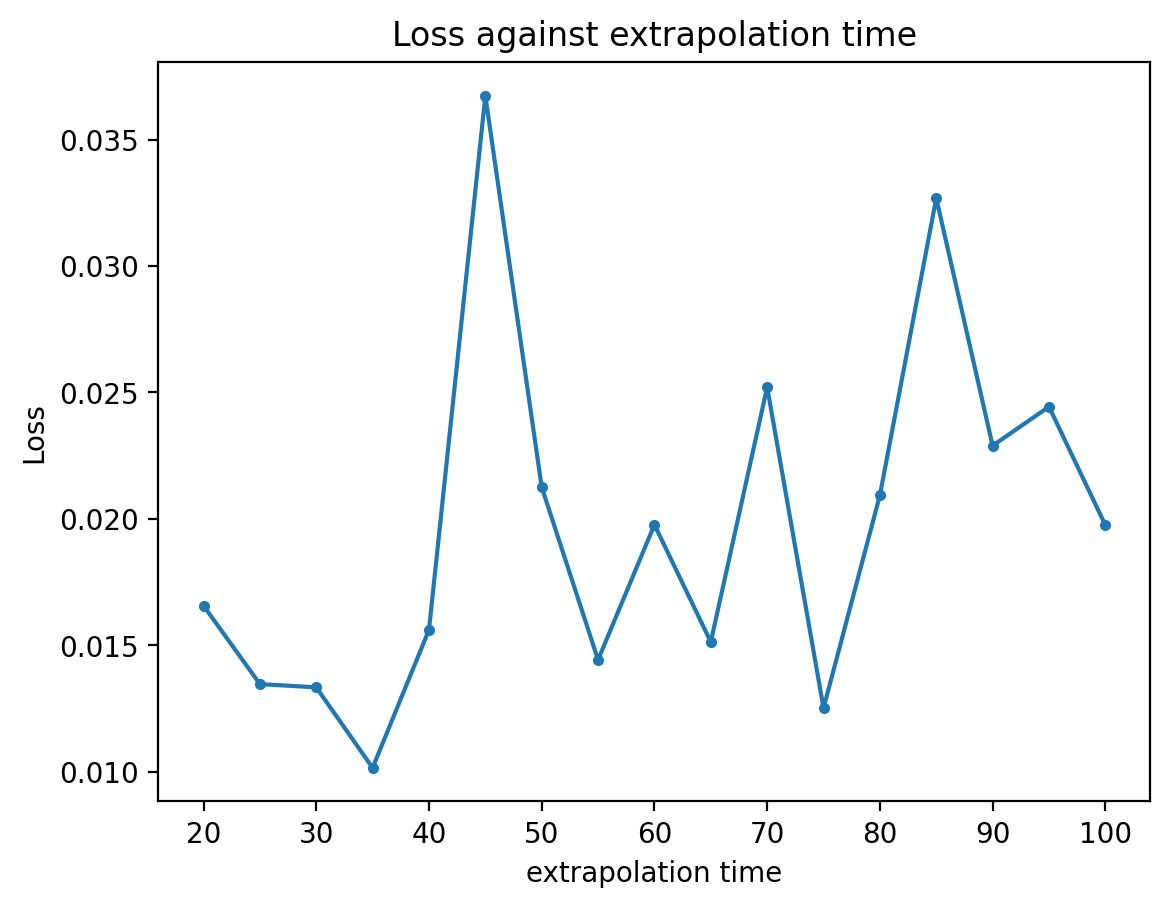

In [23]:
#Plot the loss over the different offsets
plt.figure()
plt.plot(np.arange(20,101,5), loss_3, '.-')
plt.xlabel("extrapolation time")
plt.ylabel("Loss")
plt.title("Loss against extrapolation time")
plt.show()

### Comments:
- As we can see the loss over offsets come to a minimum at 35 offsets with a loss of less than 0.009, which is a pretty good loss for our model the offset choosen before (20) gives a loss of around 0.016, which is not a bad result but as we can see 35 offsets could potentially be a better choice.
-  When choosing larger offsets values of (80,100) we can see that the loss increases as our model starts performing worst and less accurate.

## Task 4
- Repeat steps 1-3 for the initial conditions 𝑧0=[𝜋/2,0,𝜋/2,0] which give a much more complex path.

1. Train a recurrent neural network to predict the future positions, where future is defined as 𝑡=𝑡0+20𝛿𝑡, of the masses 𝑚1 and 𝑚2.

100%|███████████████████████████████████████| 1000/1000 [01:21<00:00, 12.24it/s]


5/5 [==============================] - 0s 7ms/step
Do you want to plot the cost functions of test and train (yes/no) yes


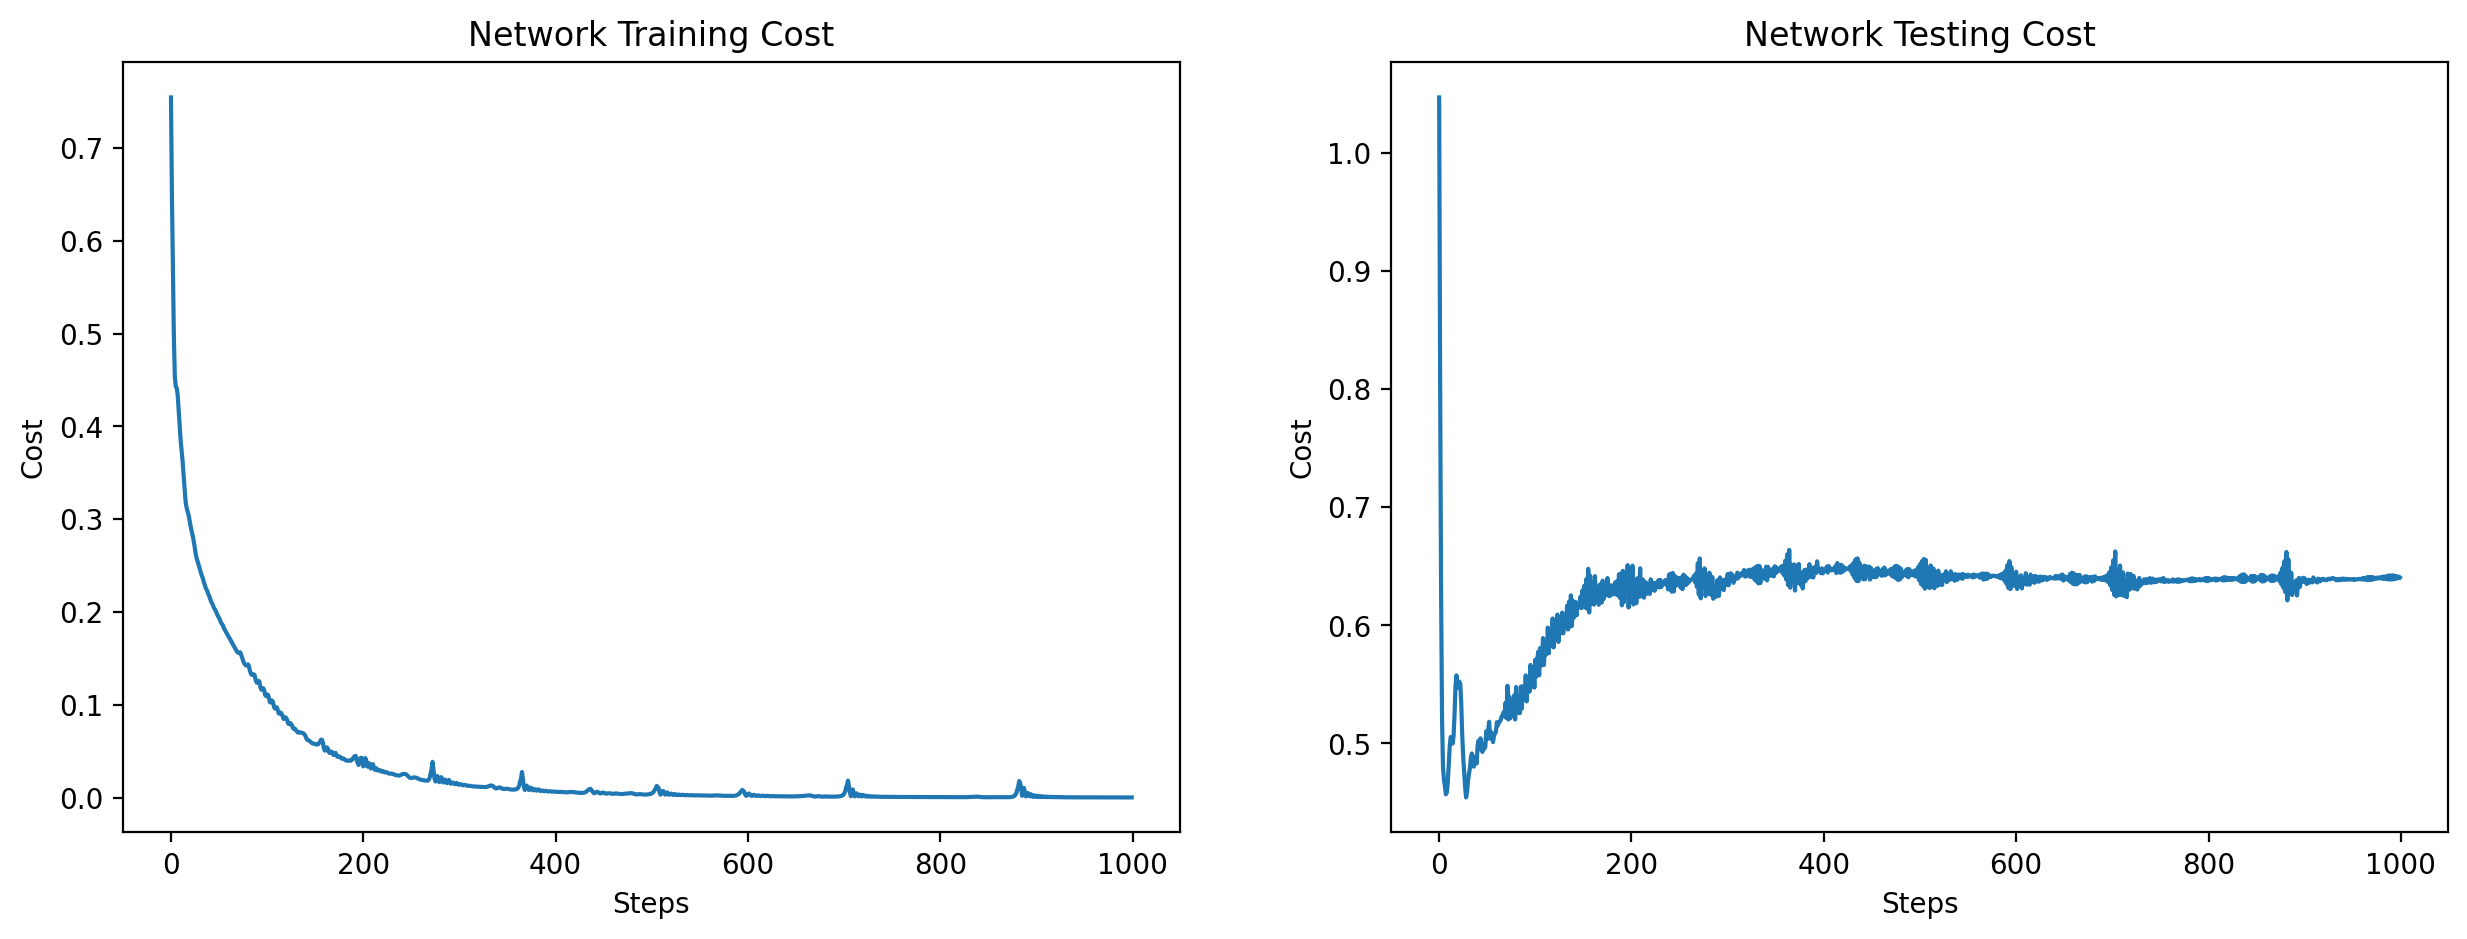

In [24]:

#Starting angles (new)
z_4=[np.pi/2,0,np.pi/2,0]

#Get predicted model, original model and cost wiht new initial angles
pred_4,pend_sol_4,cost_4, t_4=account_variations(z_4,tmax,dt,rnn,steps,windowsize,offset)


### Comments:
- The system becomes chaotic with the new initial conditions and therefore the testing cost increases and leads to a more chaotic behaviour

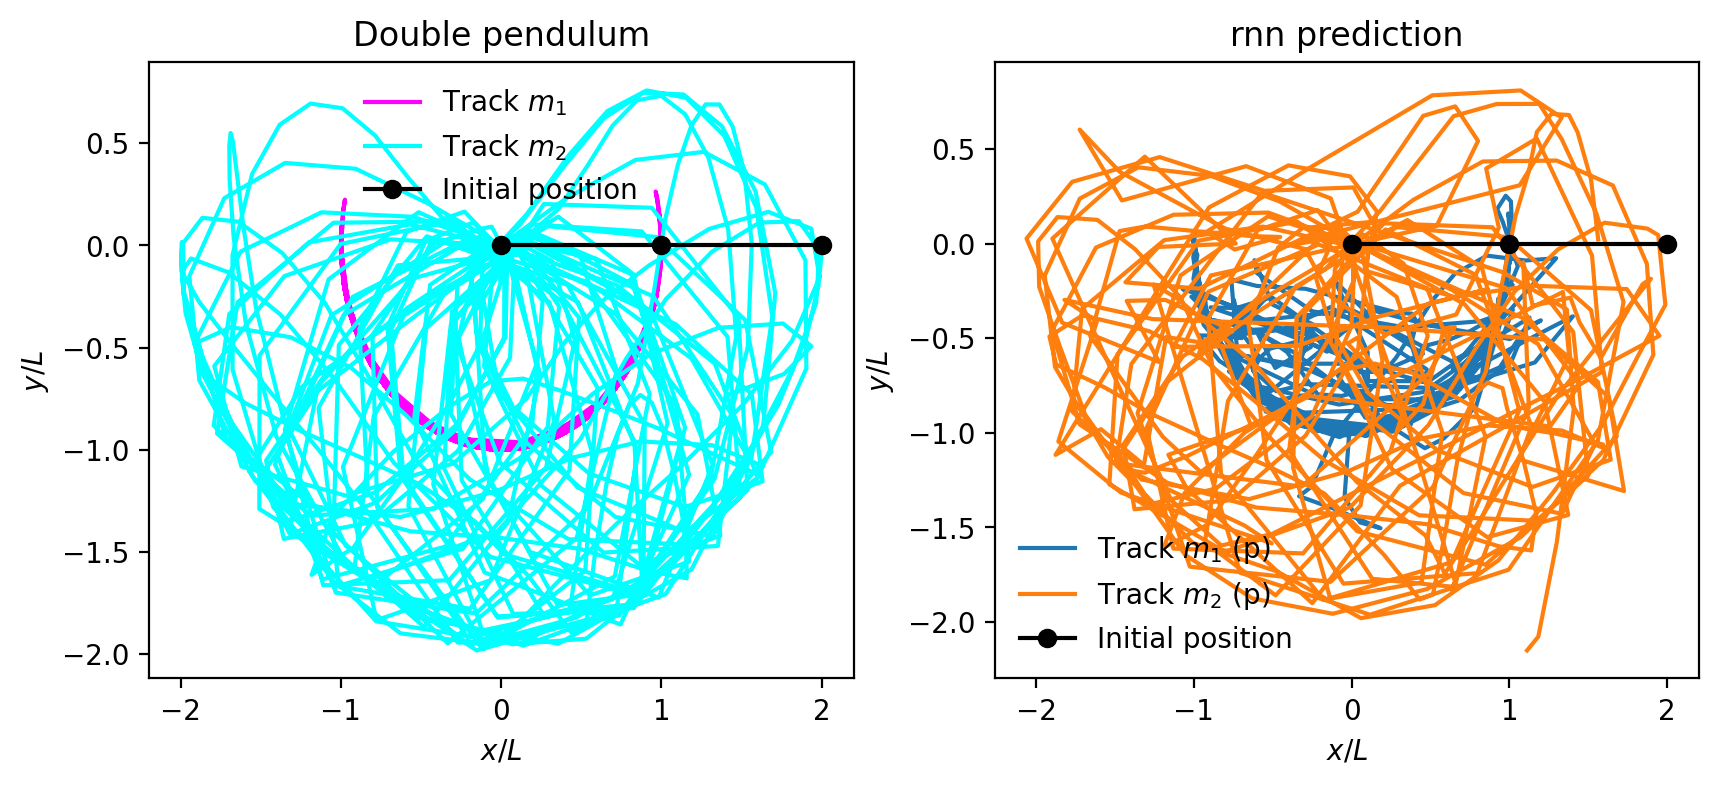

In [25]:
#Comparative plot of predicted vs original
comparative_plot(pred_4,pend_sol_4)

2. Plot of 𝑥 and 𝑦 vs time to show the network prediction in comparison to the solution from solve_ivp

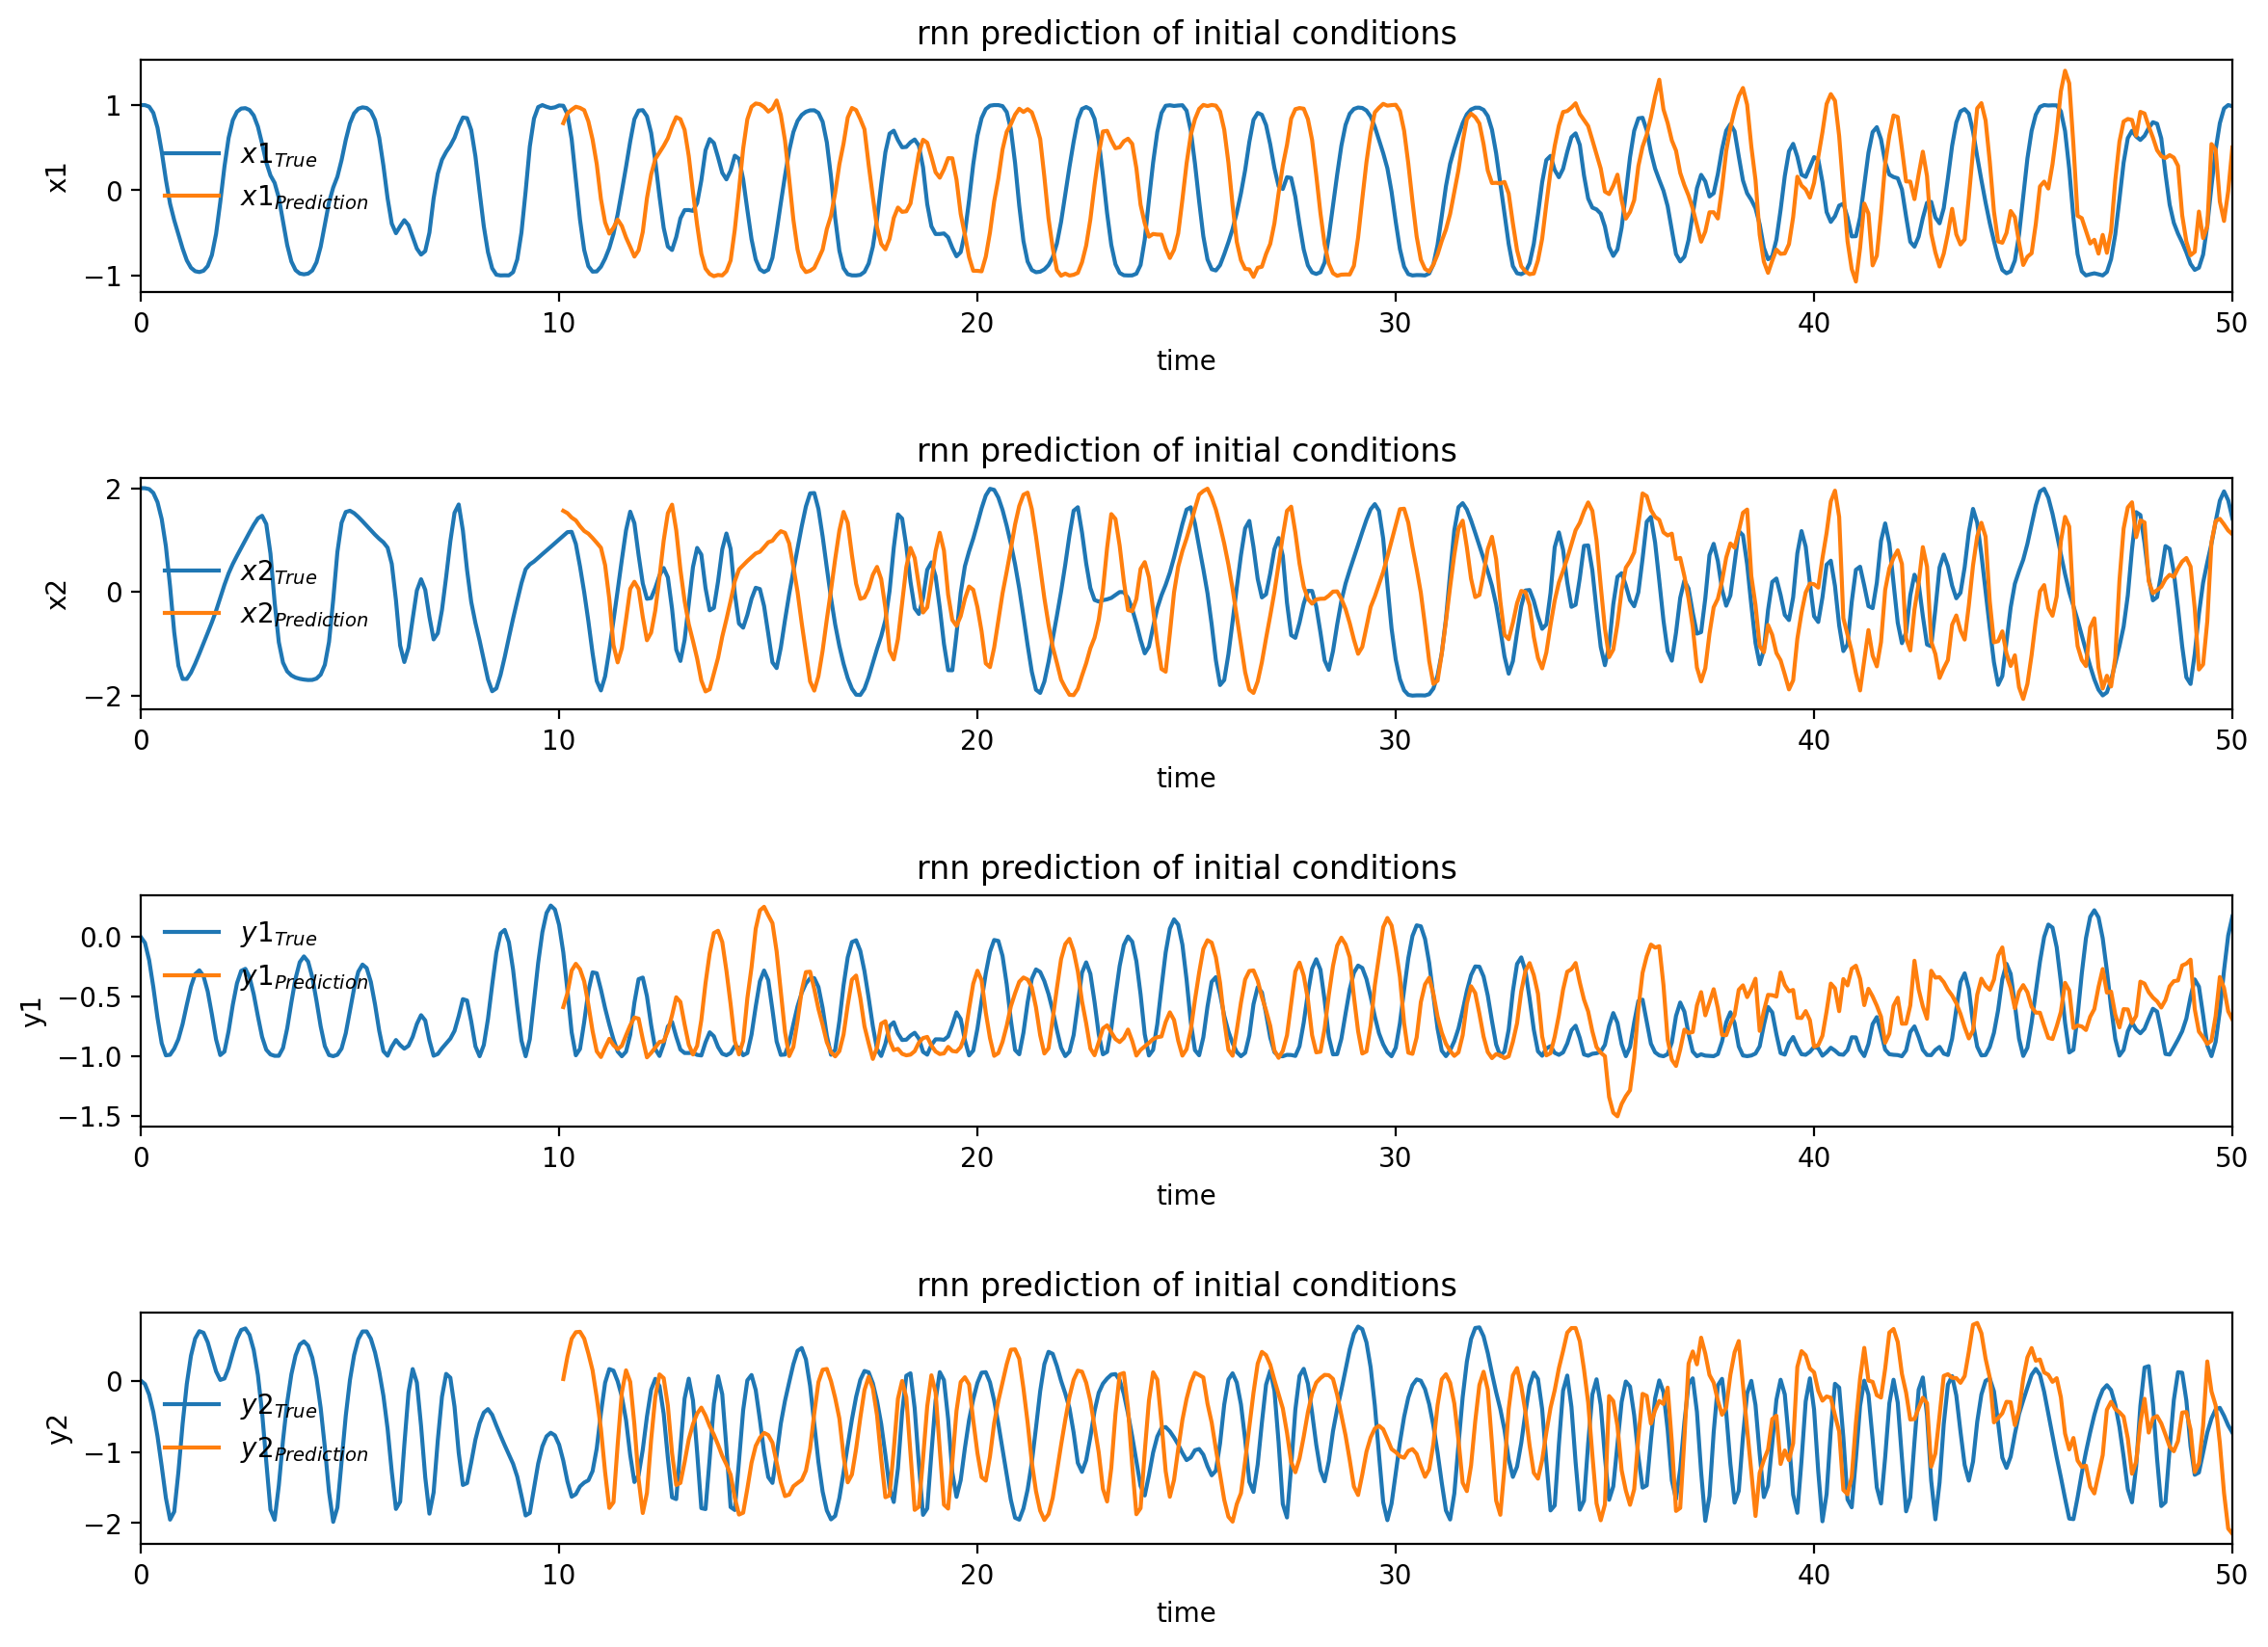

In [26]:
#Plot x and y over time
plot_motion_overtime(pred_4,pend_sol_4,t,tlim)


### Comments:
- For this case a small deviation in inital conditions lead to a chaotic systesm that we can't predict thats why the plot over time is much worse and there is no periodicity

- Peformance of the rnn reduces and the positions are not accurate compared to before.

3. Plot showing how the deviation between predicted position and actual position (from solve_ivp above) vary as a function of extrapolation time from 𝑡=𝑡0+20𝛿𝑡 to 𝑡=𝑡0+100𝛿𝑡 (e.g. for each extrapolation time, train a new version of the network and then plot the performance)

In [27]:

#store array again same as before
model_array_4=[]
for i in range(17):
    modelgen_4 = modelgenerator()
    model_array_4.append(modelgen_4)

#loss function over different offsets with new initial angles
loss_4=train_offsets(z_4,offset_3,windowsize,model_array_4)


3/3 [==============================] - 0s 9ms/step - loss: 0.9194


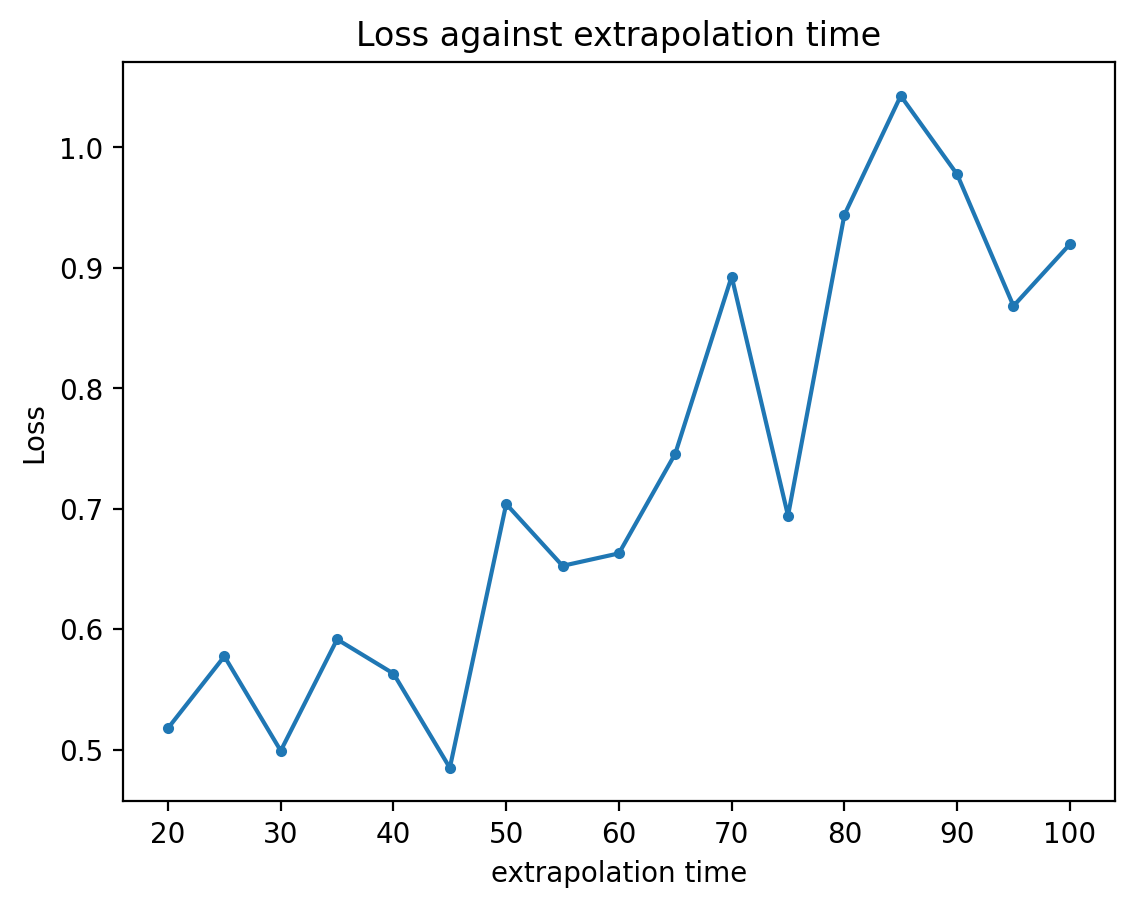

In [28]:
#plot loss over range of offsets
plt.figure()
plt.plot(np.arange(20,101,5), loss_4, '.-')
plt.xlabel("extrapolation time")
plt.ylabel("Loss")
plt.title("Loss against extrapolation time")
plt.show()

## Comments
- As we can see in this case the best offset value is 30 and it increases more or less linearly with increasing offsets with a maximum at 85.
- For this more chaotic system the performance reduces with larger offsets

## Task 5
- Repeat steps 1-4 but only train your neural network on the cartesian coordinates of the mass 𝑚2 (i.e without showing your neural network the positions of the mass 𝑚1)

1. Design and train a recurrent neural network (of your choice) to predict the future positions, where future is defined as 𝑡=𝑡0+20𝛿𝑡, of the masses 𝑚1 and 𝑚2 using their cartesian coordinates and the initial conditions 𝑧0=[𝜋/4,0,𝜋/4,0].

In [29]:
def model_oneye():
    '''Generates rnn model using a LSTM layer'''
    genmodel=keras.models.Sequential()

    #LSTM layer with 50 neurons (Input shape of 2 since only one mass will be feeded)
    genmodel.add(keras.layers.LSTM(50,input_shape=(None, 2))) 
    #Flatten
    genmodel.add(keras.layers.Flatten())
    genmodel.add(keras.layers.Dense(192, activation='relu'))        
    genmodel.add(keras.layers.Dense(2, activation='linear'))       
    #Compile model with 'adam' optimizer
    genmodel.compile(loss='mean_squared_error',optimizer='adam')
    
    return genmodel

#generate the model
model5=model_oneye()


# Solve initial value problem
ret5 = solve_ivp(rhs, (0,tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
z5=ret5.y


# Extract result
theta1_5, w1_5, theta2_5, w2_5 = z5[0], z5[1], z5[2], z5[3]
x1_5, y1_5, x2_5, y2_5, vx1, vy1, vx2, vy2 = to_cartesian(theta1_5, w1_5, theta2_5, w2_5, L1, L2)
solution_5=(x1_5,x2_5,y1_5,y2_5)


#train (60%)
y2_train_5 = y2_5[0:int(0.6*len(y2_5))]
x2_train_5 = x2_5[0:int(0.6*len(x2_5))]

#test (40%)
y2_test_5 = y2_5[int(0.6*len(y2_5)):-1]
x2_test_5 = x2_5[int(0.6*len(x2_5)):-1]
x1_test_5=x1_5[int(0.6*len(x1_5)):-1]
y1_test_5=y1_5[int(0.6*len(y1_5)):-1] 


#make array for training and testing for m1 and m2 separately
data_test2 = np.column_stack((x2_test_5, y2_test_5)).T
data_test1 = np.column_stack((x1_test_5, y1_test_5)).T
#train data only on mass 2 (one eye)
data_train = np.column_stack((x2_train_5, y2_train_5)).T


#Get data for train and test for mass 1 and 2 separately
train_inp5, train_lbl5 = dataset_gen(data_train, offset, windowsize)
test_inp5, test_lbl5 = dataset_gen(data_test1, offset, windowsize)
test2_inp5, test2_lbl5 = dataset_gen(data_test2, offset, windowsize)





In [31]:
def trainer_cost_1M(model, train_inp5, train_lbl5, test_inp1, test_inp2, steps):
    '''empty'''
        
    #Compile model to ensure that it is not trained
    model.compile(loss='mean_squared_error', optimizer='adam')
    train_costs=np.zeros(steps)
    test_costs=np.zeros(steps)

    for i in tqdm(range(steps)):
        #Reshape input and labels training data so that it fits and can be inputted into the rnn
        input_t = train_inp5.reshape(train_inp5.shape[0], windowsize, train_inp5.shape[1])
        label_t = train_lbl5.reshape(train_lbl5.shape[0],train_inp5.shape[1])
        train_costs[i] = model.train_on_batch(input_t, label_t)

    #Reshape train and test data
    input_test1 = test_inp1.reshape(test_inp1.shape[0], windowsize, test_inp1.shape[1])
    input_test2 = test_inp2.reshape(test_inp2.shape[0], windowsize, test_inp2.shape[1])
    
    #Predictions on the test data
    pred_test1 = model.predict(input_test1)
    pred_test2 = model.predict(input_test2)


    return train_costs, pred_test1, pred_test2



#Predictions and cost functions
train_costs5 , pred_test1, pred_test2= trainer_cost_1M(model5, train_inp5, train_lbl5, test_inp5, test2_inp5, steps)



100%|███████████████████████████████████████| 1000/1000 [01:08<00:00, 14.64it/s]


5/5 [==============================] - 0s 8ms/step


Final loss of  0.0019782022573053837


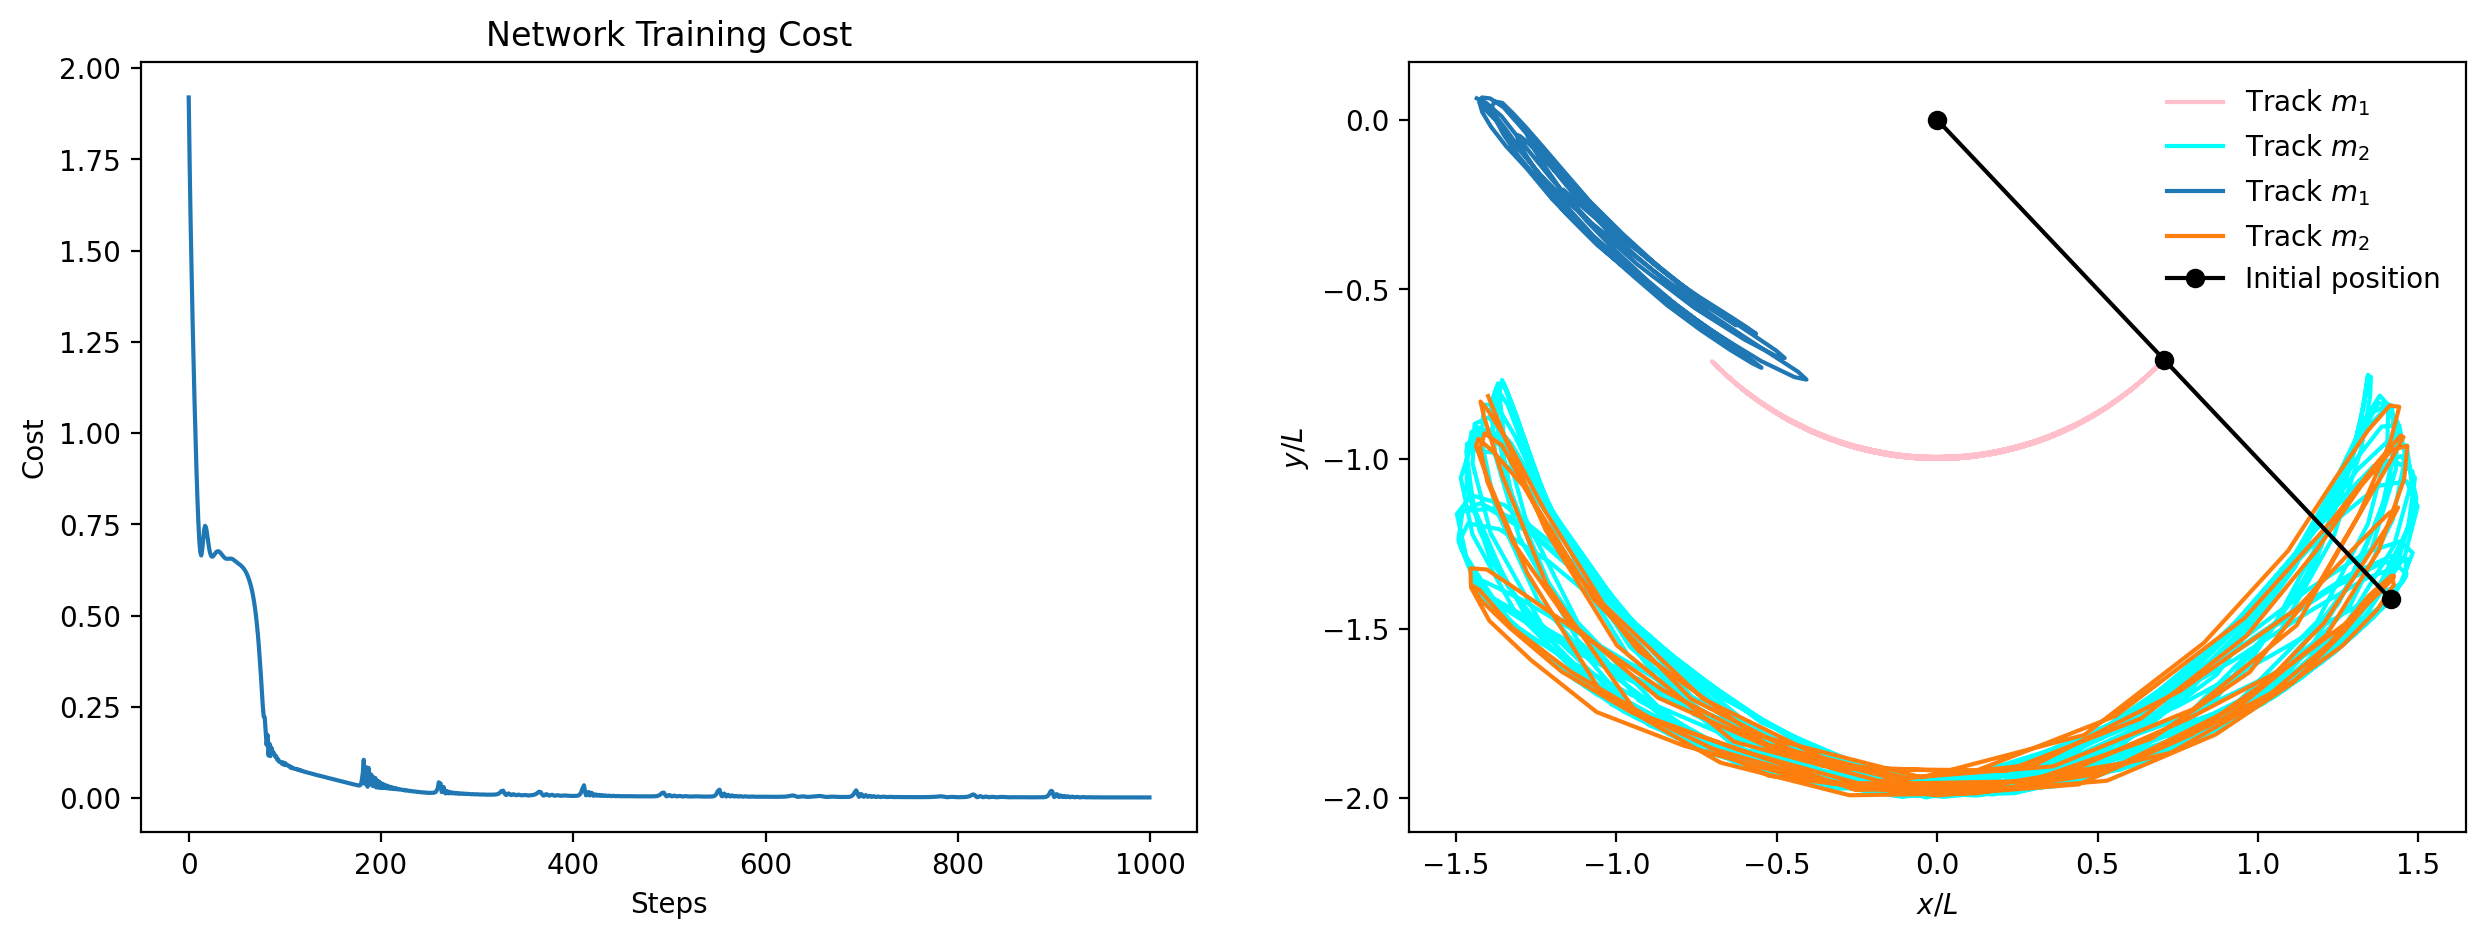

In [32]:
#Cost function of model and plot of prediction and original
costmodelplot(train_costs5, steps,pred_test1[:,0], pred_test1[:,1], pred_test2[:,0], pred_test2[:,1],x1, x2, y1, y2)



### Comments:
- We can see how for the training over one mass only the prediction of the network is much worse adn the reuslt is not a good approximation

2. How stable is your network to variations in initial conditions? Make a plot of 𝑥 and 𝑦 vs time to show the network prediction in comparison to the solution from solve_ivp

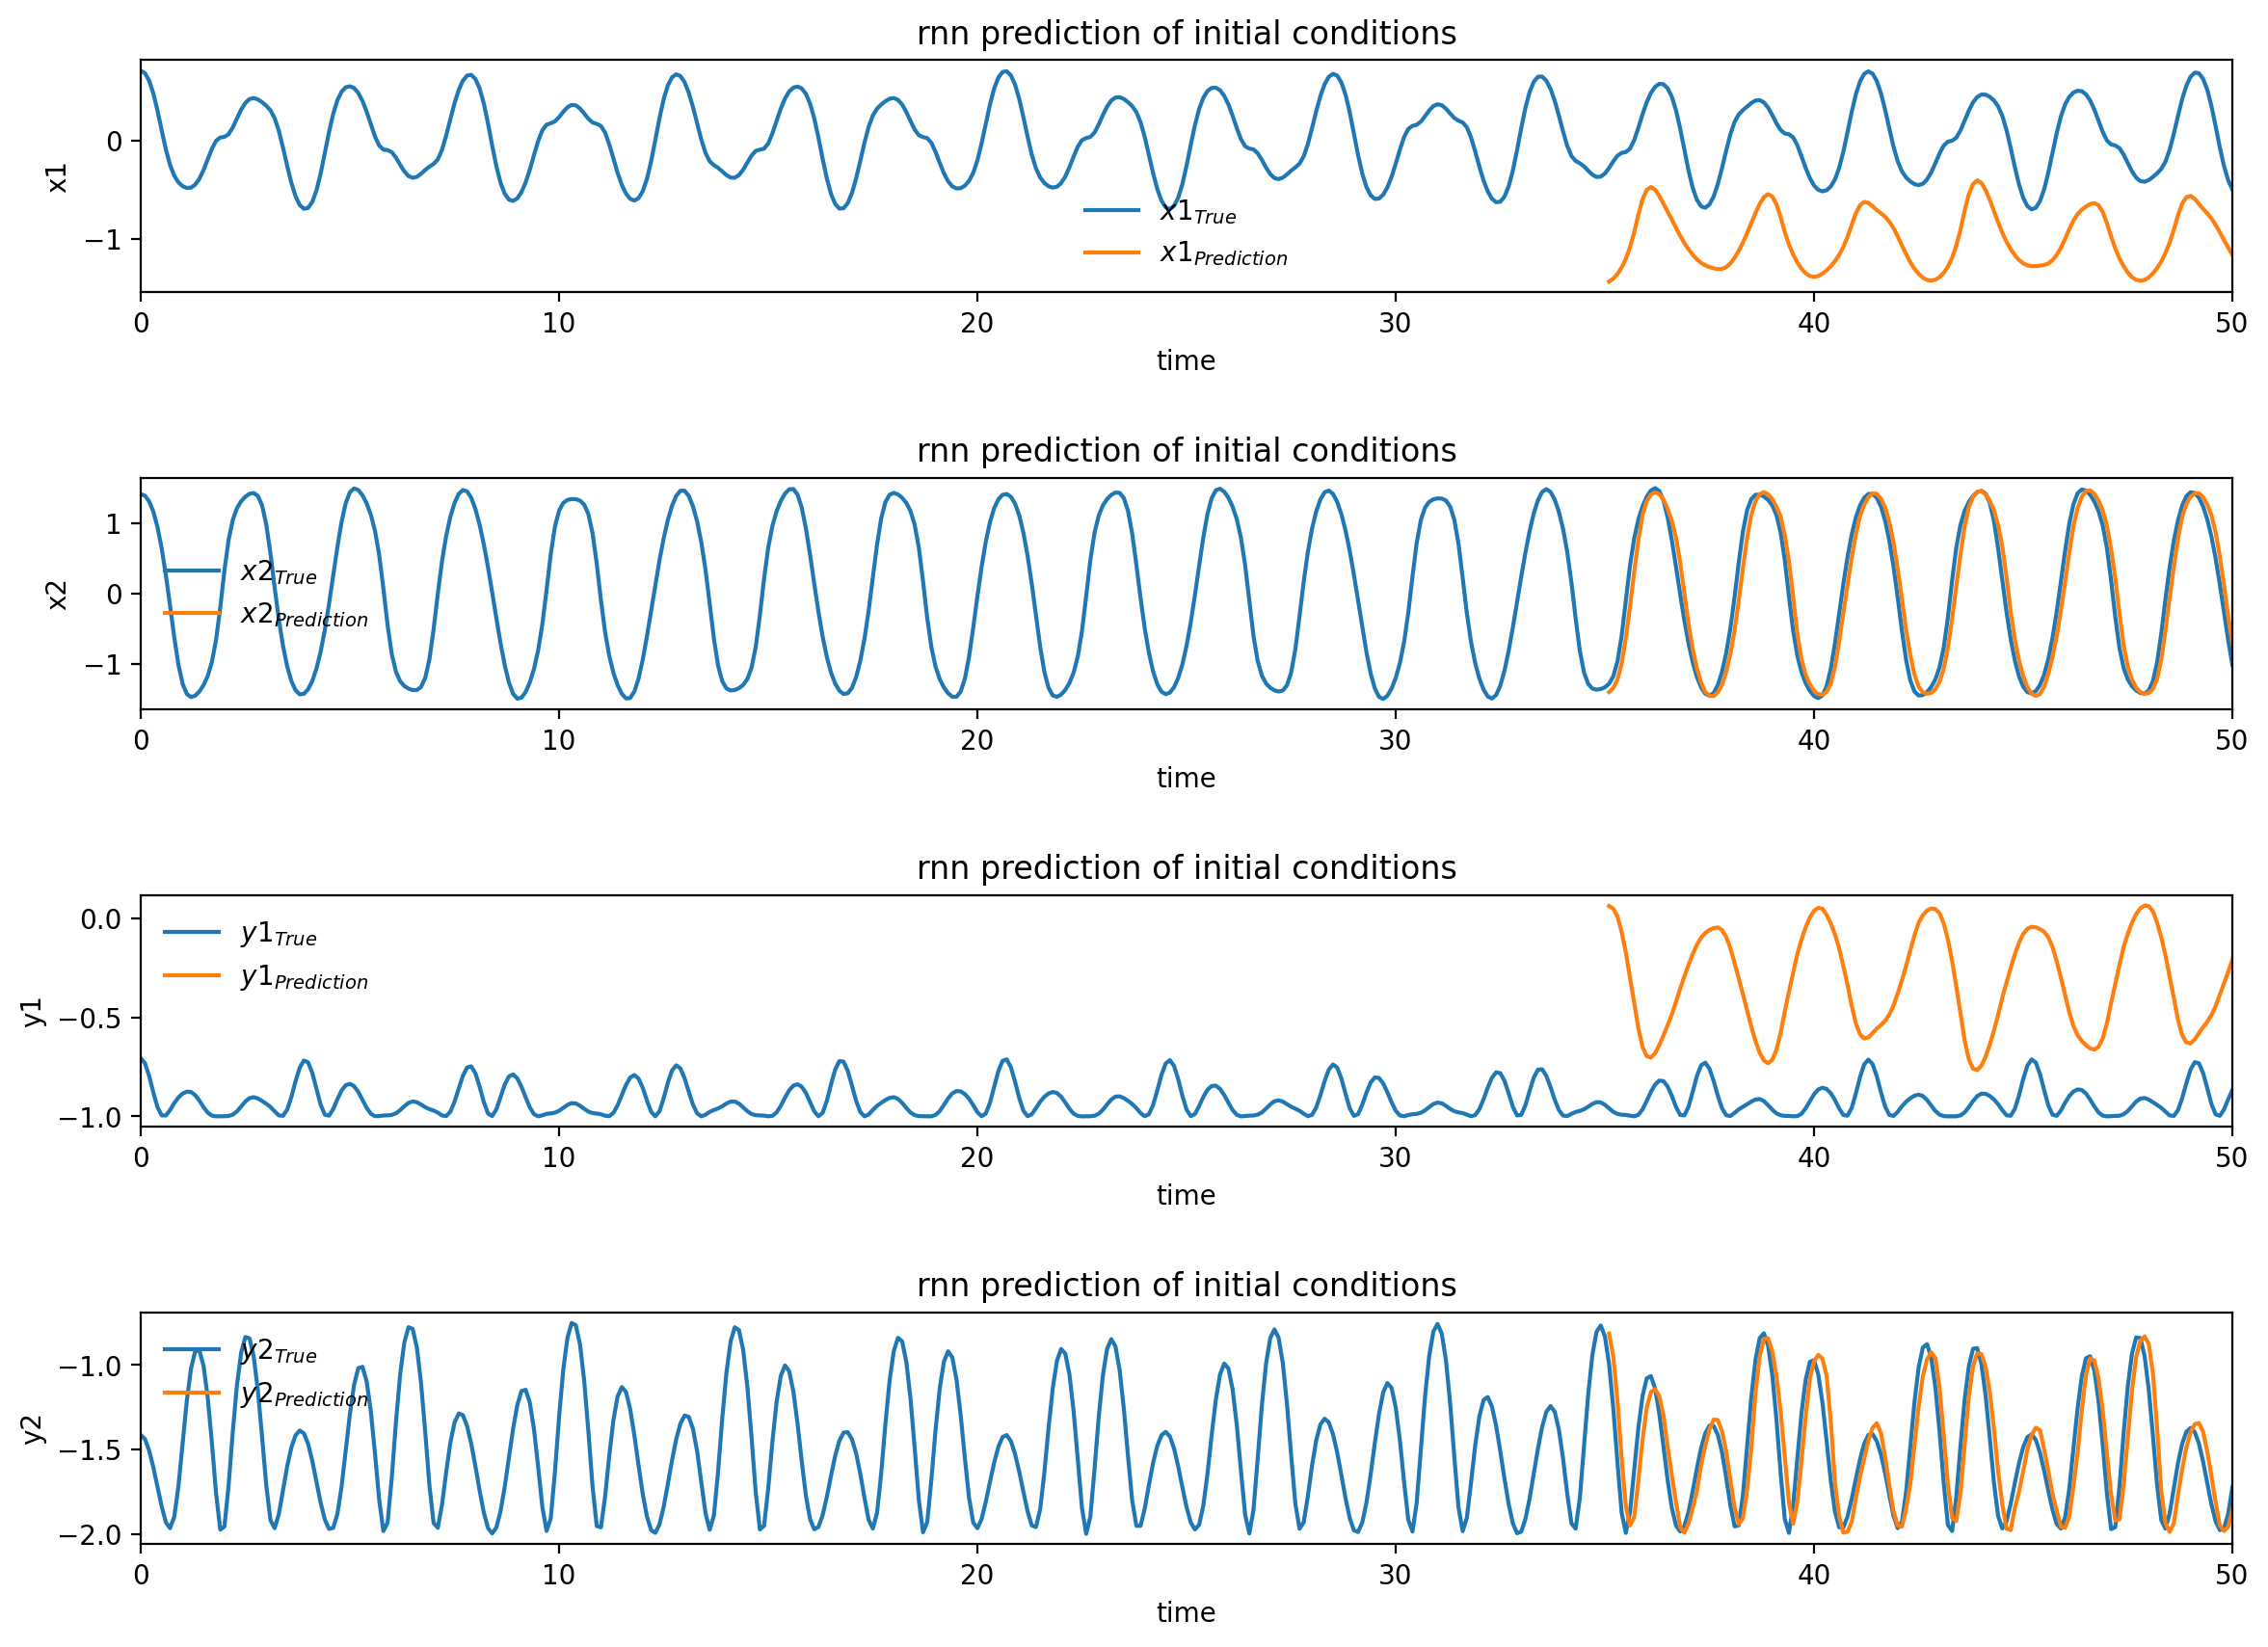

In [33]:
#stack together the test predictions for masses
test=np.column_stack((pred_test1,pred_test2))

#x and y positions original and predicted
plot_motion_overtime(test,solution_5,t,tlim)


### Comments:
- Only for the more positions of the mass2 can teh rnn approximate the double pendulum model since its been trained on that mass positions.

1 EYE MODEL:
RNN WITH INITIAL CONDITIONS ($\pi/3$, 0,$\pi/3$, 2)


100%|███████████████████████████████████████| 1000/1000 [01:07<00:00, 14.89it/s]


5/5 [==============================] - 0s 6ms/step
Final loss of  0.00032401279895566404


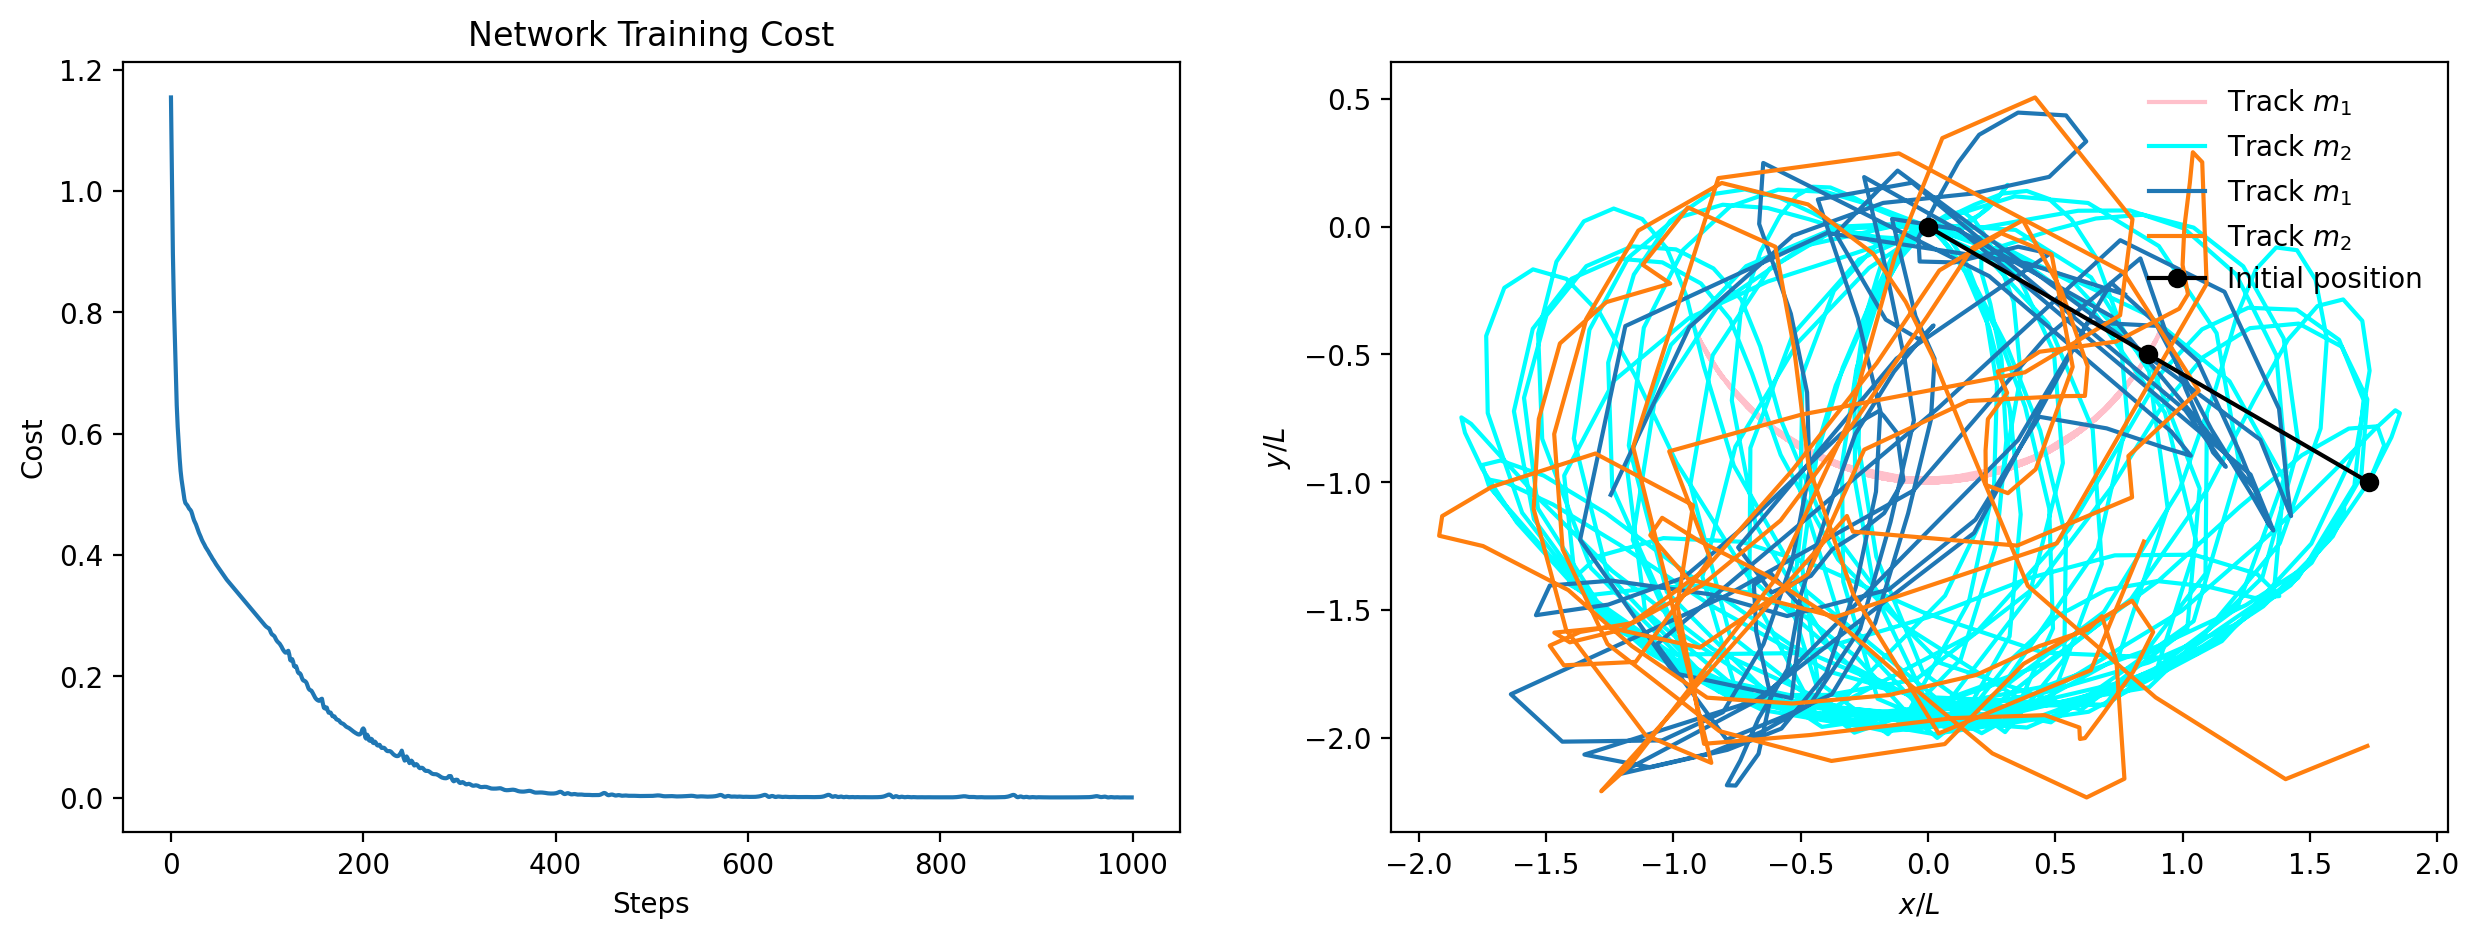

In [35]:
def account_variationsM1(zi,tmax,dt,model=rnn,steps=steps,windowsize=windowsize,offset=offset):
    '''Function that checks for variations'''
    
    #####################################################################################
    # First lets get new results of x1,x2,y1,y2 for the variation on initial conditions #
    #####################################################################################
    
    #Initial conditions
    z0=zi
    #New time to avoid problems
    t = np.arange(0, tmax+dt, dt)
    ret5 = solve_ivp(rhs, (0,tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
    z5=ret5.y


    # Extract result
    theta1_5, w1_5, theta2_5, w2_5 = z5[0], z5[1], z5[2], z5[3]
    x1_5, y1_5, x2_5, y2_5, vx1, vy1, vx2, vy2 = to_cartesian(theta1_5, w1_5, theta2_5, w2_5, L1, L2)
    solution_5=(x1_5,x2_5,y1_5,y2_5)


    #train (60%)
    y2_train_5 = y2_5[0:int(0.6*len(y2_5))]
    x2_train_5 = x2_5[0:int(0.6*len(x2_5))]

    #test (40%)
    y2_test_5 = y2_5[int(0.6*len(y2_5)):-1]
    x2_test_5 = x2_5[int(0.6*len(x2_5)):-1]
    x1_test_5=x1_5[int(0.6*len(x1_5)):-1]
    y1_test_5=y1_5[int(0.6*len(y1_5)):-1]


    #make array for training and testing for m1 and m2 separately
    data_test2 = np.column_stack((x2_test_5, y2_test_5)).T
    data_test1 = np.column_stack((x1_test_5, y1_test_5)).T
    #train data only on mass 2
    data_train = np.column_stack((x2_train_5, y2_train_5)).T

    windowsize=30

    train_inp5, train_lbl5 = dataset_gen(data_train, offset, windowsize)
    test_inp5, test_lbl5 = dataset_gen(data_test1, offset, windowsize)
    test2_inp5, test2_lbl5 = dataset_gen(data_test2, offset, windowsize)

    
    
        ###############################################################################
        #  Now let's repeat part 1 create data to predict the double pendulum system  #
        ###############################################################################


    train_costs5 , pred_test1, pred_test2= trainer_cost_1M(model, train_inp5, train_lbl5, test_inp5, test2_inp5, steps)

                                                

                ###############################################################
                #  Now let's plot our results for the double pendulum system  #
                ###############################################################
    costmodelplot(train_costs5, steps,pred_test1[:,0], pred_test1[:,1], pred_test2[:,0], pred_test2[:,1],x1_5, x2_5, y1_5, y2_5)


    return train_costs5 , pred_test1, pred_test2, t, solution_5

#Training over z_var the same as in task 1 (π/2,0,π/2,3)
train_cost_v5,pred1_v5,pred2_v5,t_5, sol_v5=account_variationsM1(z_var,tmax,dt,model5,steps,windowsize,offset)


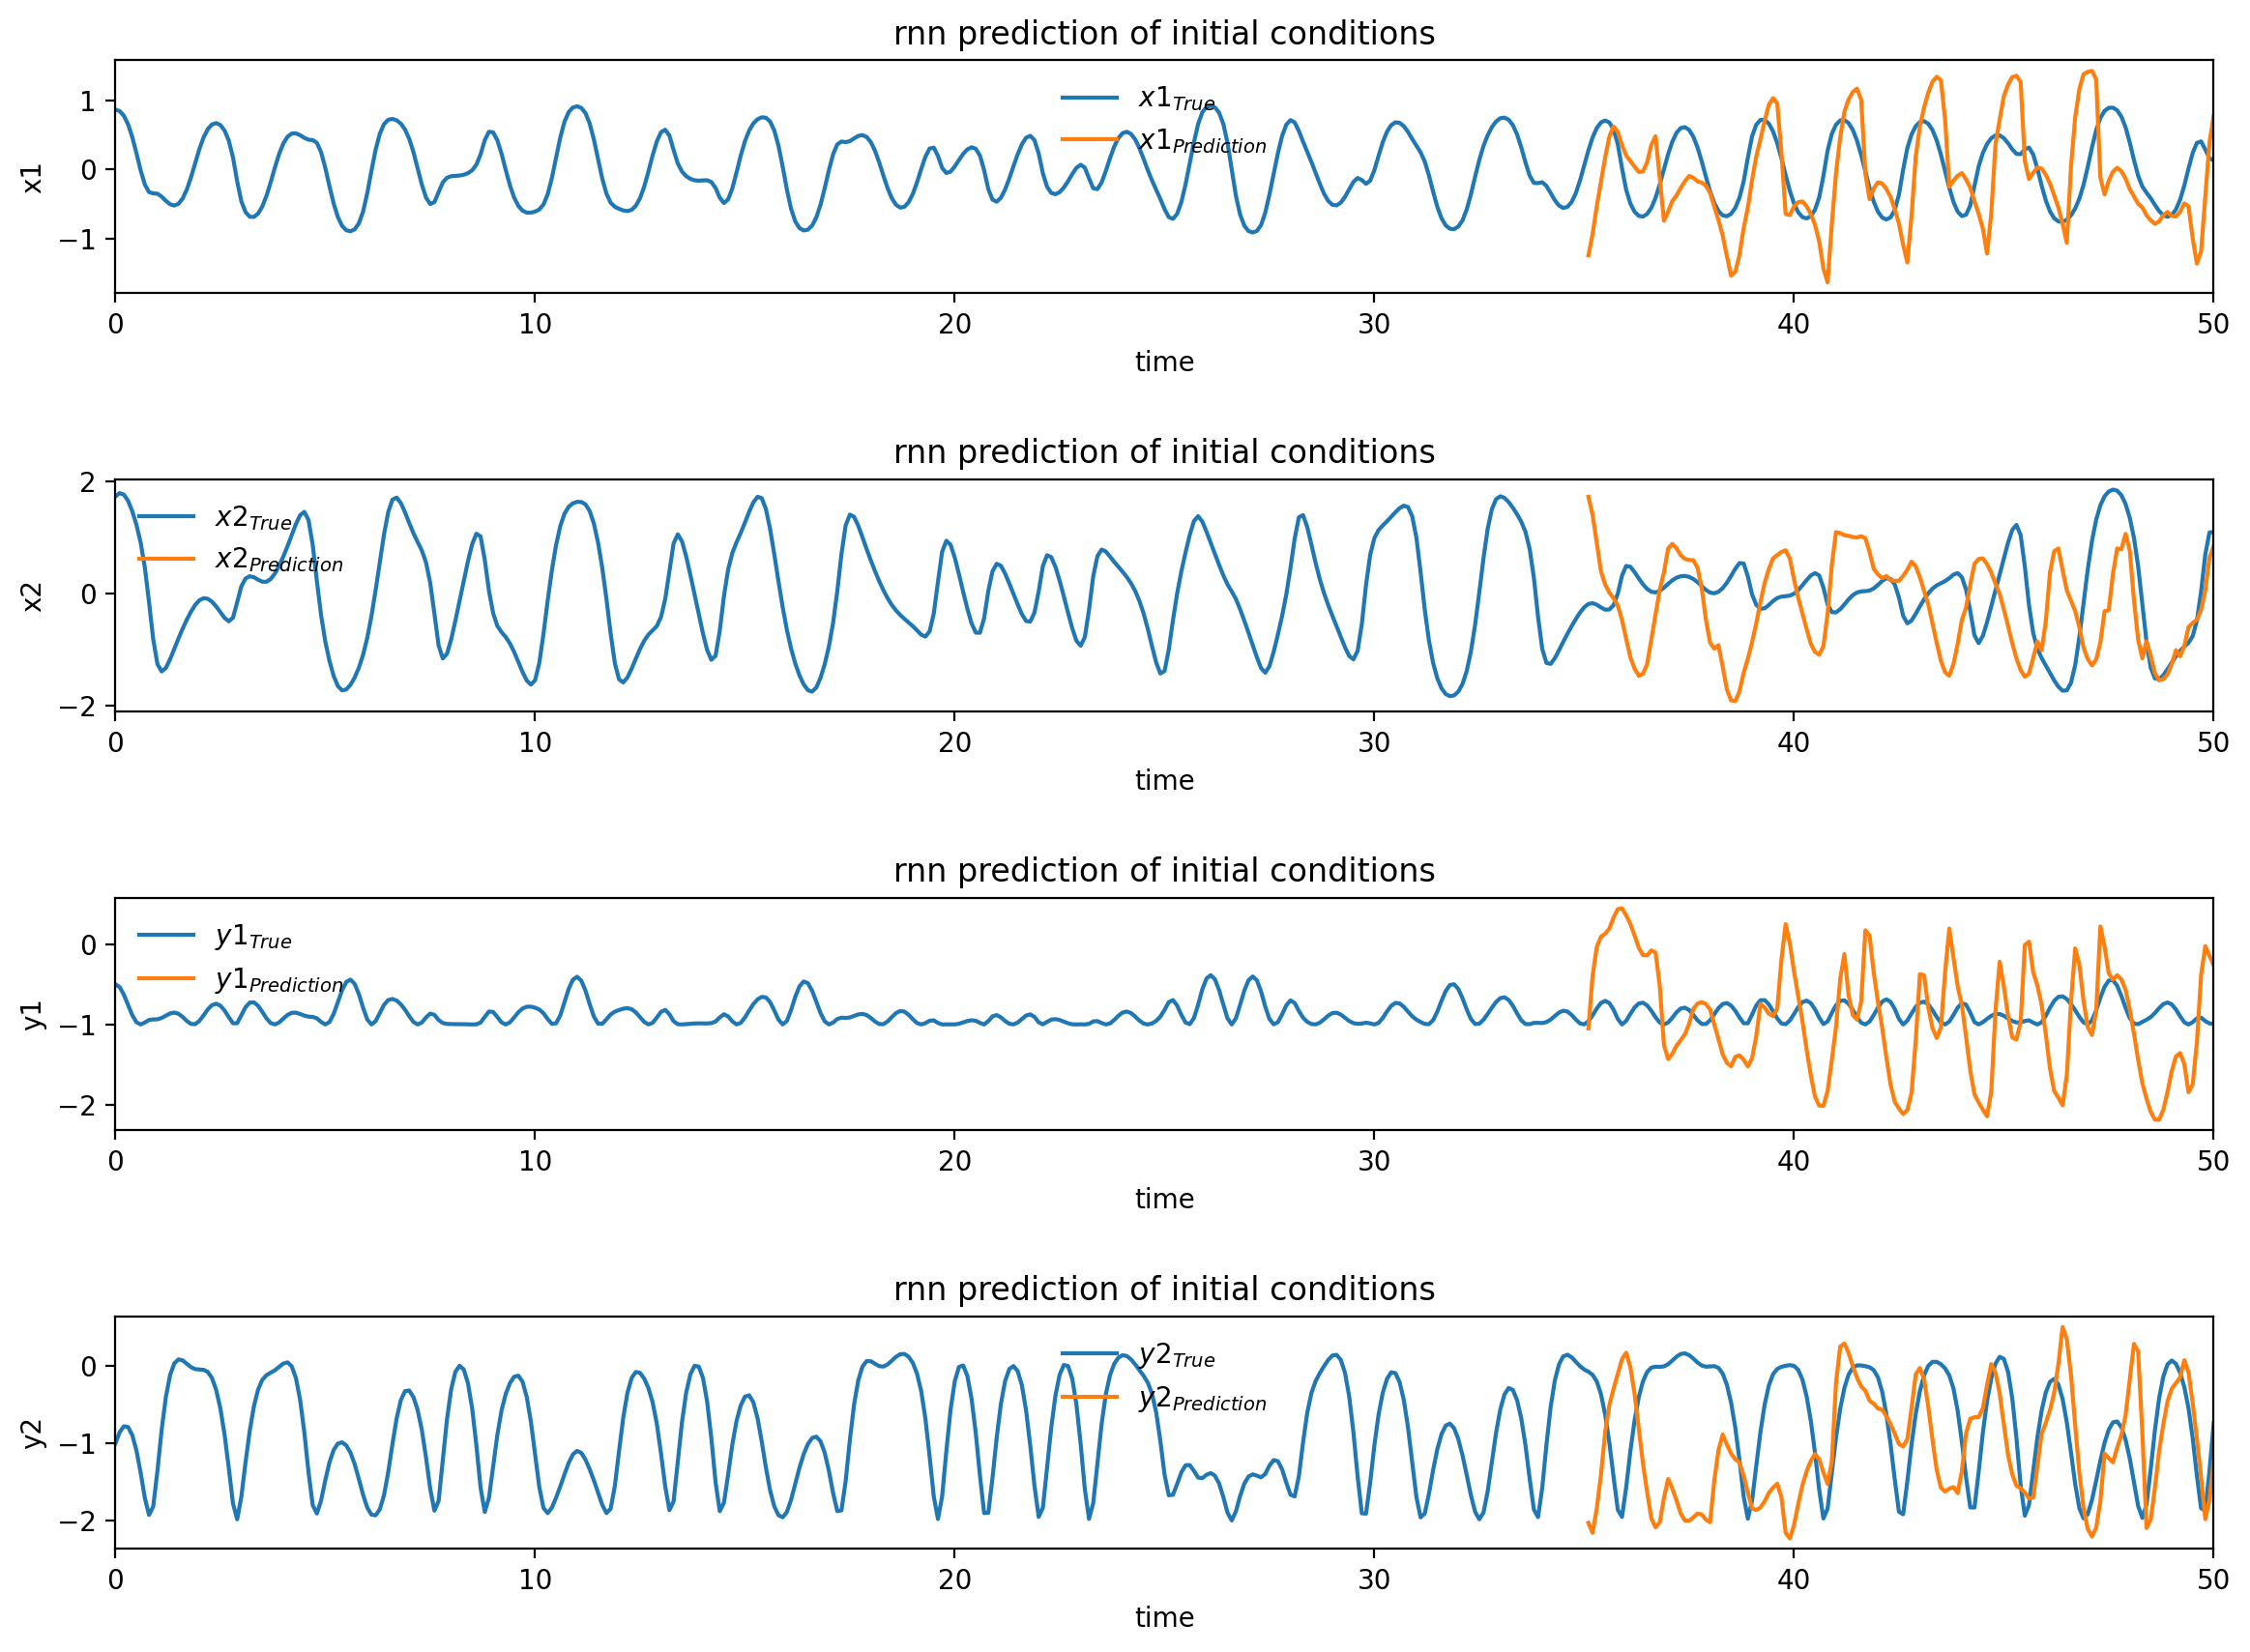

In [36]:
#Stack together results again
test_v5=np.column_stack((pred1_v5,pred2_v5))

#Motion on x and y over time
plot_motion_overtime(test_v5,sol_v5,t,tlim)


### Comments:
- Changing the initial positions leads to a chaotic system even harder to predict now for our model since its trained in half the data and the reuslt is a really poor approximation.

3. How far into the future can a network predict? Make a plot showing how the deviation between predicted position and actual position (from solve_ivp above) vary as a function of extrapolation time from 𝑡=𝑡0+20𝛿𝑡 to 𝑡=𝑡0+100𝛿𝑡 (e.g. for each extrapolation time, train a new version of the network and then plot the performance)

In [37]:
#Let's find this deviation as a function of extrapolation time from 𝑡=𝑡0+20𝛿𝑡 to 𝑡=𝑡0+100𝛿𝑡

#define model generator to create x models to train over teh different offsets
def modelgenerator_5():
    genmodel=keras.models.Sequential()

    #LSTM layer with 50 neurons
    genmodel.add(keras.layers.LSTM(50,input_shape=(None, 2)))    
    genmodel.add(keras.layers.Flatten())                           
    genmodel.add(keras.layers.Dense(192, activation='relu'))      
    #2 output since its only trained on one mass (x-y)
    genmodel.add(keras.layers.Dense(2, activation='linear'))       
    genmodel.compile(loss='mean_squared_error',optimizer='adam')
    
    return genmodel

#using the offset from task 3
offset_3=(20,101,5)
#store all the 17 models
model_array_5 = []

for i in range(17):
    modelgen = modelgenerator_5()
    model_array_5.append(modelgen)
    
    

In [38]:
def train_offsets_1M(zi,offsets,windowsize,models_array):

    #New time to avoid problems
    t = np.arange(0, tmax+dt, dt)
    ret5 = solve_ivp(rhs, (0,tmax), zi, t_eval=t, args=(L1, L2, m1, m2, g))
    z5=ret5.y


    # Extract result
    theta1_5, w1_5, theta2_5, w2_5 = z5[0], z5[1], z5[2], z5[3]
    x1_5, y1_5, x2_5, y2_5, vx1, vy1, vx2, vy2 = to_cartesian(theta1_5, w1_5, theta2_5, w2_5, L1, L2)
    solution_5=(x1_5,x2_5,y1_5,y2_5)


    #train (60%)
    y2_train_5 = y2_5[0:int(0.6*len(y2_5))]
    x2_train_5 = x2_5[0:int(0.6*len(x2_5))]

    #test (40%)
    y2_test_5 = y2_5[int(0.6*len(y2_5)):-1]
    x2_test_5 = x2_5[int(0.6*len(x2_5)):-1]
    x1_test_5=x1_5[int(0.6*len(x1_5)):-1]
    y1_test_5=y1_5[int(0.6*len(y1_5)):-1]



    #make array for training and testing for m1 and m2 separately
    data_test2 = np.column_stack((x2_test_5, y2_test_5)).T
    data_test1 = np.column_stack((x1_test_5, y1_test_5)).T
    #train data only on mass 2
    data_train = np.column_stack((x2_train_5, y2_train_5)).T

    
    #offsets
    offset_3=range(*offsets)

    #storages for 
    inp_train_3=[]
    lbl_train_3=[]
    inp_test1_3=[]
    lbl_test1_3=[]
    inp_test2_3=[]
    lbl_test2_3=[]
    

    for offset in offset_3:
        #training and testing datasets for RNN
        train_inp_3, train_lbl_3 = dataset_gen(data_train,offset,windowsize)
        test_inp1_3, test_lbl1_3 = dataset_gen(data_test1,offset,windowsize)
        test_inp2_3, test_lbl2_3 = dataset_gen(data_test2,offset,windowsize)


        
        #reshape to ()
        input_train=train_inp_3.reshape(train_inp_3.shape[0],windowsize, train_inp_3.shape[1])
        label_train=train_lbl_3.reshape(train_lbl_3.shape[0], train_inp_3.shape[1])
        input_test1=test_inp1_3.reshape(test_inp1_3.shape[0],windowsize, test_inp1_3.shape[1])
        label_test1=test_lbl1_3.reshape(test_lbl1_3.shape[0], test_lbl1_3.shape[1])
        input_test2=test_inp2_3.reshape(test_inp2_3.shape[0],windowsize, test_inp2_3.shape[1])
        label_test2=test_lbl2_3.reshape(test_lbl2_3.shape[0], test_lbl2_3.shape[1])

        inp_train_3.append(input_train)
        lbl_train_3.append(label_train)
        inp_test1_3.append(input_test1)
        lbl_test1_3.append(label_test1)
        inp_test2_3.append(input_test2)
        lbl_test2_3.append(label_test2)
        
    #TRAINING
    #store loss
    loss1=[]
    loss2=[]

    for i in range(len(offset_3)):
        model_5=model_array_5[i]
        history_5=model_5.fit(inp_train_3[i], lbl_train_3[i], epochs=33, verbose=0)
        test_loss1 = model_5.evaluate(inp_test1_3[i], lbl_test1_3[i] , verbose=1)
        test_loss2 = model_5.evaluate(inp_test2_3[i], lbl_test2_3[i] , verbose=1)
        loss1.append(test_loss1)
        loss2.append(test_loss2)

        
    return loss1, loss2
        

In [39]:
#losses of both masses
loss1, loss2=train_offsets_1M(z0,offset_3,windowsize,model_array_5)



3/3 [==============================] - 0s 11ms/step - loss: 0.0763


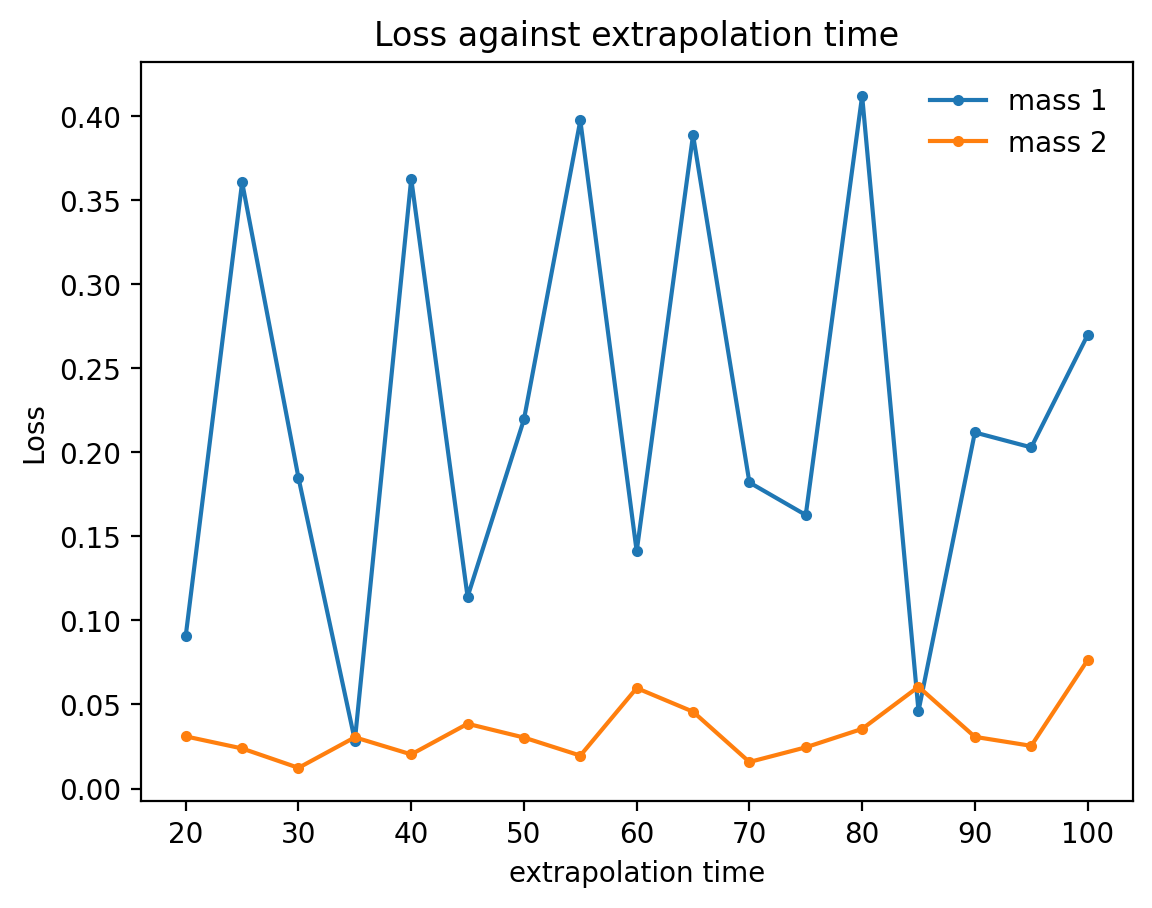

In [40]:
#Plot of loss over offsets
plt.figure()
plt.plot(np.arange(20,101,5), loss1, '.-', label='mass 1')
plt.plot(np.arange(20,101,5), loss2, '.-',label='mass 2')
plt.legend()
plt.xlabel("extrapolation time")
plt.ylabel("Loss")
plt.title("Loss against extrapolation time")
plt.show()

### Comments:
- For mass 2 (the mass that has been trained on) the loss over offsets is much better with a minimum at 30 more or less as in the previous case and for the case of mass 1 the loss over extrapolation time varies a lot to tell what would be a good resutl but potentially 60 could be a minimum however more analysis might be needed.

4.  SAME BUT WIHT 𝑧0=[𝜋/2,0,𝜋/2,0]

100%|███████████████████████████████████████| 1000/1000 [01:28<00:00, 11.33it/s]


5/5 [==============================] - 0s 7ms/step
Final loss of  0.00036268180701881647


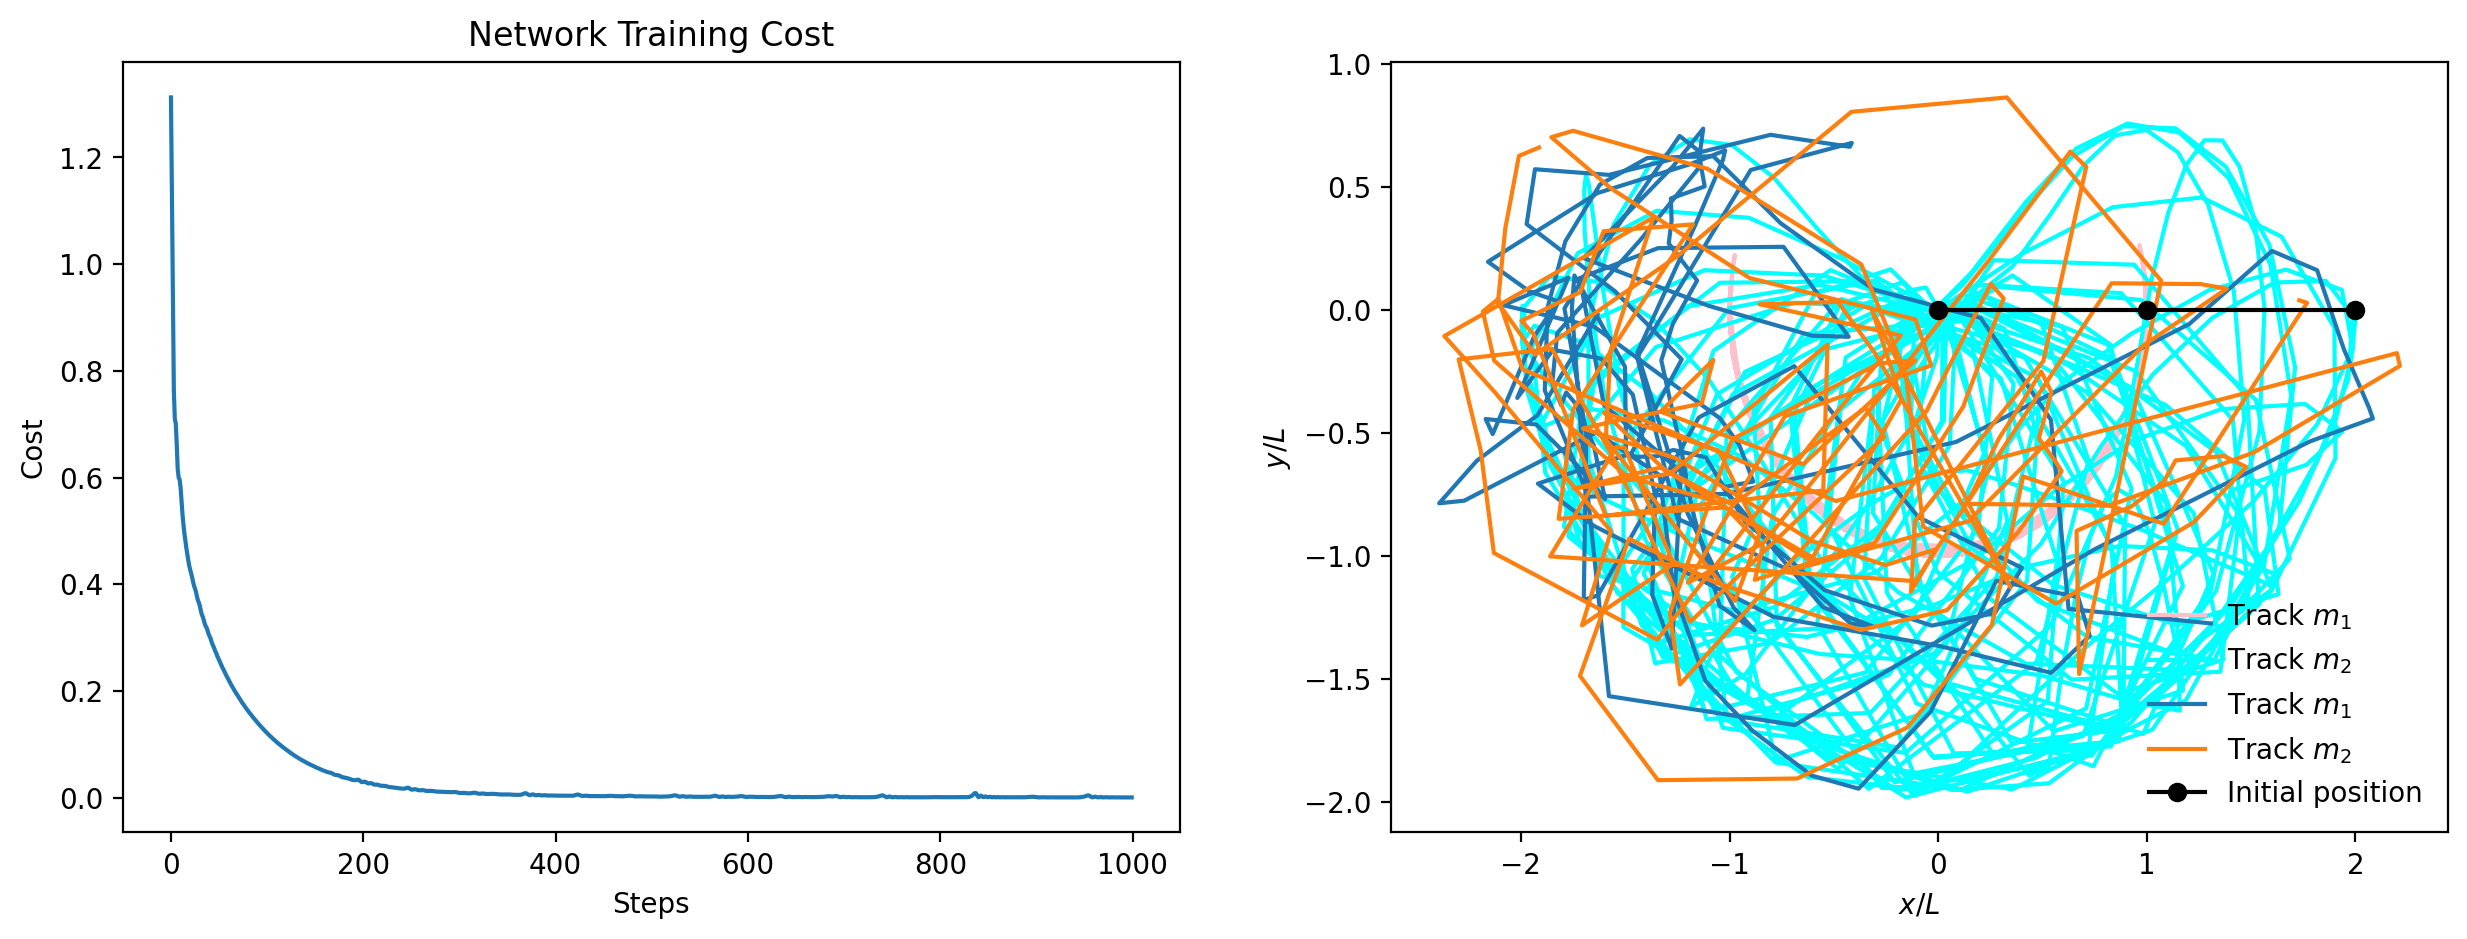

In [41]:

#Starting angles (as before)
z_4=[np.pi/2,0,np.pi/2,0]


train_costVAR5,pred1VAR5,pred2VAR5,t_v5, solVAR5 =account_variationsM1(z_4,tmax,dt,model5,steps,windowsize,offset)



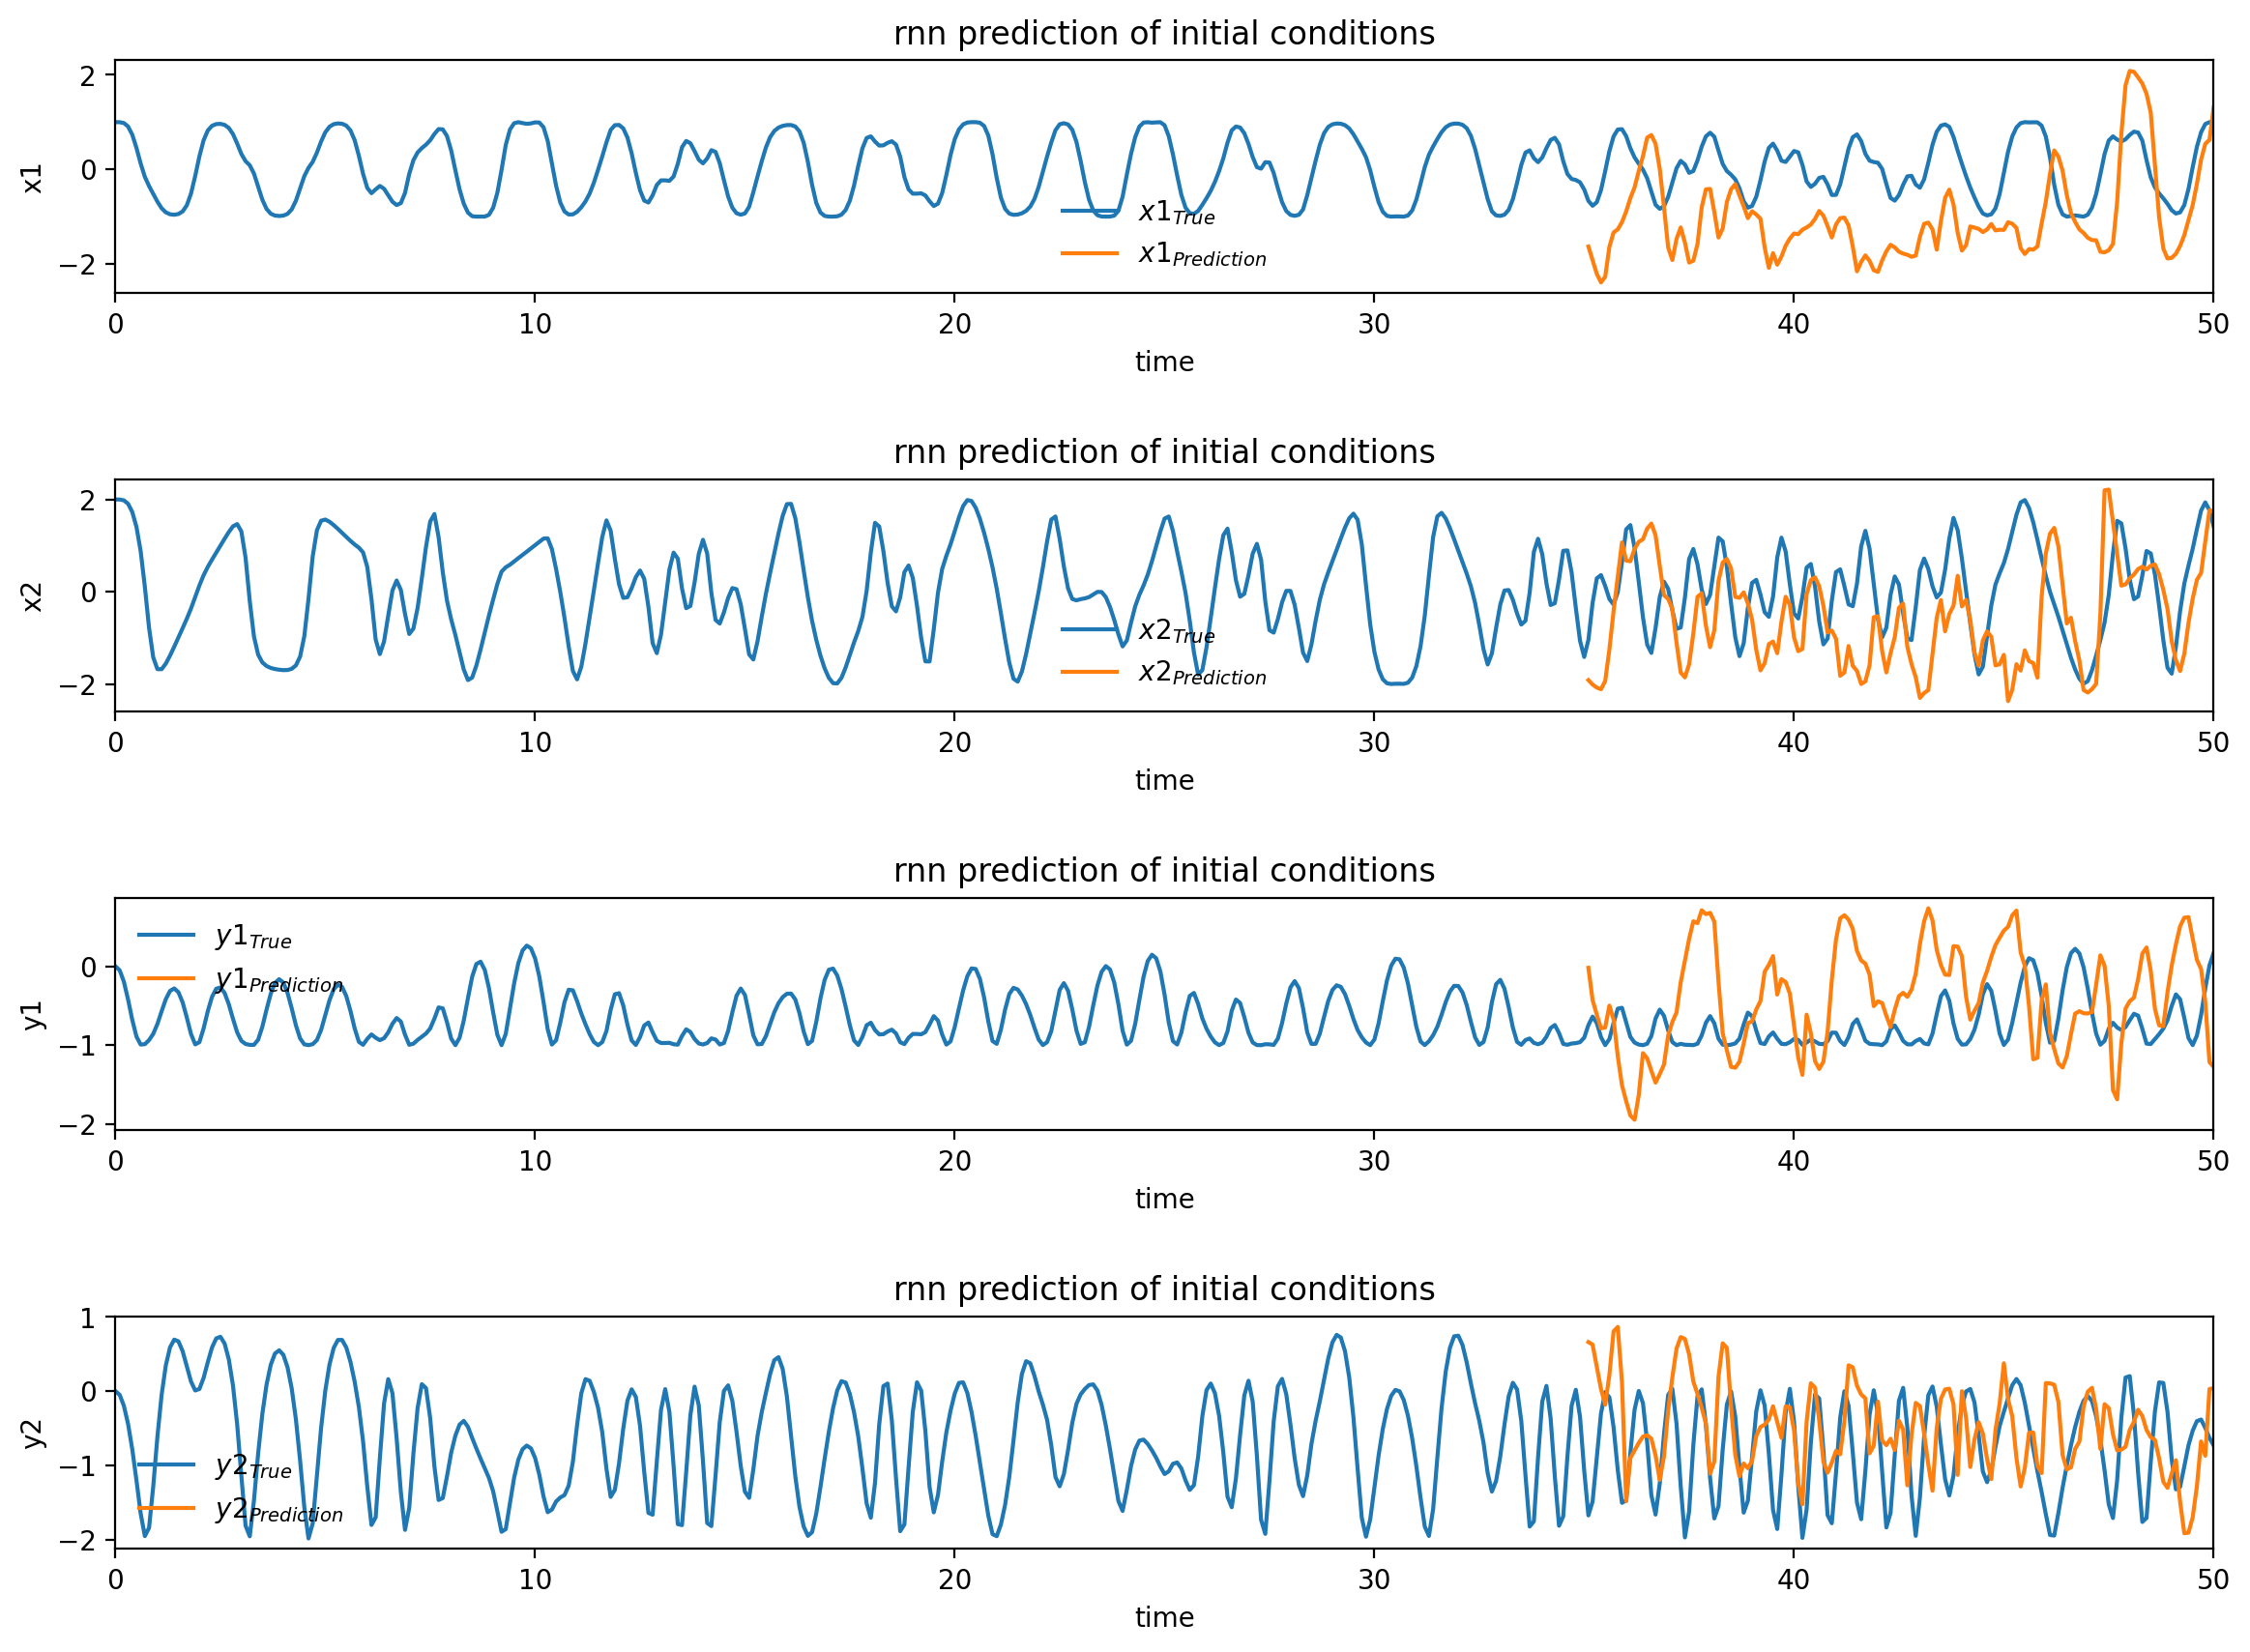

In [42]:
#stack predictions
testVAR5=np.column_stack((pred1VAR5,pred2VAR5))
#motion over time
plot_motion_overtime(testVAR5,solVAR5,t_v5,tlim)


In [43]:
#same as before
offset_4=(20,101,5)

model_arrayVAR5=[]
for i in range(17):
    modelgenVAR5 = modelgenerator_5()
    model_arrayVAR5.append(modelgenVAR5)
    
loss1V5, loss2V5=train_offsets_1M(z_4,offset_4,windowsize,model_arrayVAR5)


3/3 [==============================] - 0s 8ms/step - loss: 1.1999


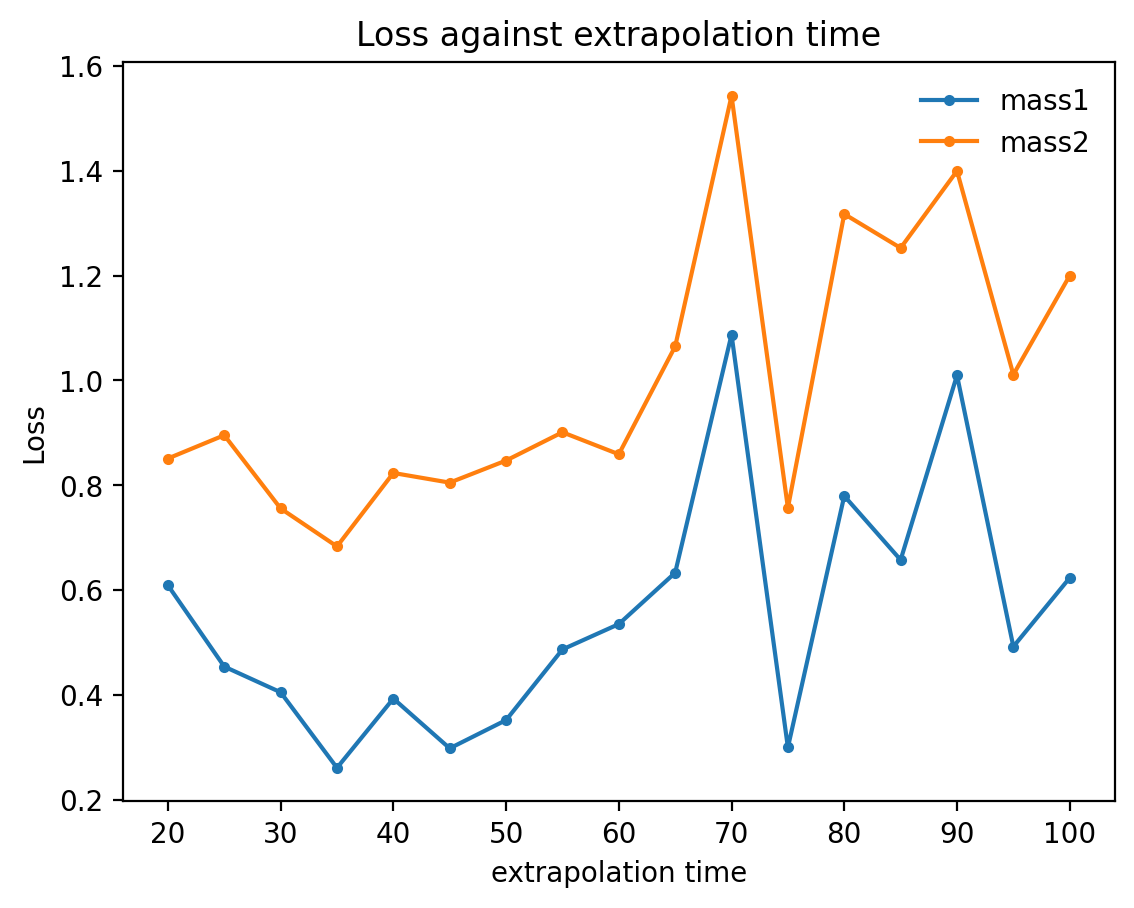

In [44]:
#Plot of loss over offsets
plt.figure()
plt.plot(np.arange(20,101,5), loss1V5, '.-',label='mass1')
plt.plot(np.arange(20,101,5), loss2V5, '.-',label='mass2')
plt.legend()
plt.xlabel("extrapolation time")
plt.ylabel("Loss")
plt.title("Loss against extrapolation time")
plt.show()

### Comments:
- For the case of changing the initial angles to (π/2,0,π/2,0) we can see that it becomes much more unpredictable over time and teh prediction doesn't fit well the data from teh solve_ivp. Giving a poor result.
- Also for the plot over extrapolation time we cna see that both test predictions have a similar loss function but with higher loss for mass 2.
